Data Exploration Code (By Kyrylo Sirik)

In [42]:
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for beautiful plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

In [43]:
# Path to the business.json file
business_file = "yelp_academic_dataset_business.json"

count_open_0 = 0
count_open_1 = 0

business_file_path = Path(business_file)

if not business_file_path.exists():
    print(f"File not found: {business_file}")
else:
    print(f"Reading from: {business_file_path.name}\n")
    
    with open(business_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line:
                try:
                    business = json.loads(line)
                    if 'is_open' in business:
                        if business['is_open'] == 0:
                            count_open_0 += 1
                        elif business['is_open'] == 1:
                            count_open_1 += 1
                except json.JSONDecodeError:
                    continue
    
    print(f"Businesses with is_open = 0 (Closed): {count_open_0:,}")
    print(f"Businesses with is_open = 1 (Open): {count_open_1:,}")
    print(f"Total businesses: {count_open_0 + count_open_1:,}")
    print(f"\nClass imbalance ratio (Open:Closed): {count_open_1/count_open_0:.2f}:1")

Reading from: yelp_academic_dataset_business.json

Businesses with is_open = 0 (Closed): 30,648
Businesses with is_open = 1 (Open): 119,698
Total businesses: 150,346

Class imbalance ratio (Open:Closed): 3.91:1


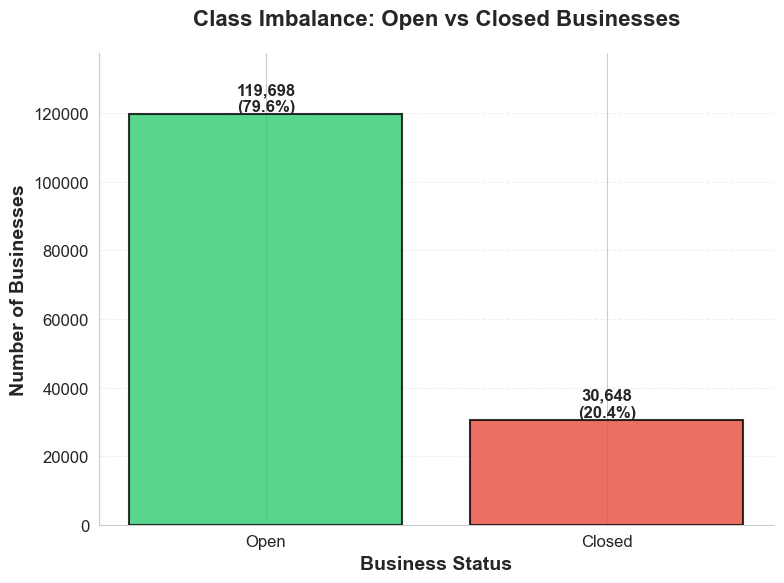

In [ ]:
# Create bar chart
categories = ['Open', 'Closed']
counts = [count_open_1, count_open_0]
colors = ['#2ecc71', '#e74c3c']  # Green for open, red for closed

fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(categories, counts, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

for i, (bar, count) in enumerate(zip(bars, counts)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{count:,}\n({count/(count_open_0 + count_open_1)*100:.1f}%)',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

# Customize the plot
ax.set_ylabel('Number of Businesses', fontsize=14, fontweight='bold')
ax.set_xlabel('Business Status', fontsize=14, fontweight='bold')
ax.set_title('Class Imbalance: Open vs Closed Businesses', fontsize=16, fontweight='bold', pad=20)
ax.set_ylim(0, max(counts) * 1.15)

# Add grid for better readability
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np

# Load review.json to compute review features
review_file = "yelp_academic_dataset_review.json"
RECENT_WINDOW_DAYS = 180
print("Loading review.json (this may take a moment)...")
reviews = []
with open(review_file, 'r', encoding='utf-8') as f:
    for i, line in enumerate(f):
        line = line.strip()
        if line:
            try:
                reviews.append(json.loads(line))
            except json.JSONDecodeError:
                continue
        if (i + 1) % 100000 == 0:
            print(f"  Parsed {i + 1:,} lines...")

review_df = pd.DataFrame(reviews)
print(f"Loaded {len(review_df):,} reviews")

# Convert date to datetime
review_df['date'] = pd.to_datetime(review_df['date'], errors='coerce')
review_df = review_df[review_df['date'].notna()].copy()

# Compute cutoff date
end_date = review_df['date'].max()
end_year = end_date.year
cutoff_year = end_year - 2
cutoff_T = pd.Timestamp(year=cutoff_year, month=12, day=31).normalize()

print(f"\nLatest review date: {end_date.date()}")
print(f"Cutoff date T: {cutoff_T.date()}")
print(f"Reviews ≤ T: {(review_df['date'] <= cutoff_T).sum():,}")
print(f"Reviews > T: {(review_df['date'] > cutoff_T).sum():,}")

Loading review.json (this may take a moment)...
  Parsed 100,000 lines...
  Parsed 200,000 lines...
  Parsed 300,000 lines...
  Parsed 400,000 lines...
  Parsed 500,000 lines...
  Parsed 600,000 lines...
  Parsed 700,000 lines...
  Parsed 800,000 lines...
  Parsed 900,000 lines...
  Parsed 1,000,000 lines...
  Parsed 1,100,000 lines...
  Parsed 1,200,000 lines...
  Parsed 1,300,000 lines...
  Parsed 1,400,000 lines...
  Parsed 1,500,000 lines...
  Parsed 1,600,000 lines...
  Parsed 1,700,000 lines...
  Parsed 1,800,000 lines...
  Parsed 1,900,000 lines...
  Parsed 2,000,000 lines...
  Parsed 2,100,000 lines...
  Parsed 2,200,000 lines...
  Parsed 2,300,000 lines...
  Parsed 2,400,000 lines...
  Parsed 2,500,000 lines...
  Parsed 2,600,000 lines...
  Parsed 2,700,000 lines...
  Parsed 2,800,000 lines...
  Parsed 2,900,000 lines...
  Parsed 3,000,000 lines...
  Parsed 3,100,000 lines...
  Parsed 3,200,000 lines...
  Parsed 3,300,000 lines...
  Parsed 3,400,000 lines...
  Parsed 3,500,000

In [ ]:
# Filter reviews up to cutoff T )
review_df_cut = review_df[review_df['date'] <= cutoff_T].copy()

# Verify required columns exist
required_cols = ['business_id', 'review_id', 'stars', 'date']
missing_cols = [col for col in required_cols if col not in review_df_cut.columns]
if missing_cols:
    raise ValueError(f"Missing required columns in review_df_cut: {missing_cols}")
print(f"Verified required columns exist: {required_cols}")

# Calculate review_length (text length) for avg_review_length computation
if 'text' in review_df_cut.columns:
    review_df_cut['review_length'] = review_df_cut['text'].astype(str).str.len()
else:
    review_df_cut['review_length'] = np.nan

# All-history aggregates up to T 
review_agg = (
    review_df_cut.groupby('business_id')
    .agg(
        n_reviews_total=('review_id', 'count'),
        avg_review_stars=('stars', 'mean'),
        std_review_stars=('stars', 'std'),
        avg_review_length=('review_length', 'mean'),
        last_review_date=('date', 'max'),
    )
)
if 'n_reviews_total' in review_agg.columns:
    review_agg['n_reviews_total'] = review_agg['n_reviews_total'].astype('int32')
review_agg['std_review_stars'] = review_agg['std_review_stars'].fillna(0.0)

# Verify aggregation columns were created
print(f"\nColumns in review_agg: {list(review_agg.columns)}")
assert 'avg_review_stars' in review_agg.columns, "avg_review_stars not in review_agg!"
assert 'std_review_stars' in review_agg.columns, "std_review_stars not in review_agg!"
assert 'last_review_date' in review_agg.columns, "last_review_date not in review_agg!"

# Recent window aggregates
window_start = cutoff_T - pd.Timedelta(days=RECENT_WINDOW_DAYS)
mask_recent = (review_df_cut['date'] >= window_start) & (review_df_cut['date'] <= cutoff_T)
review_recent_agg = (
    review_df_cut[mask_recent].groupby('business_id')
    .agg(n_reviews_recent=('review_id', 'count'))
)

# Join the features
reviews_features = review_agg.join(review_recent_agg, how='left')
reviews_features['n_reviews_recent'] = reviews_features['n_reviews_recent'].fillna(0).astype('int32')

# Verify all columns are present after join
print(f"\nBusinesses with reviews: {len(reviews_features):,}")
print(f"\nColumns in reviews_features: {list(reviews_features.columns)}")
assert 'avg_review_stars' in reviews_features.columns, "avg_review_stars missing after join!"
assert 'std_review_stars' in reviews_features.columns, "std_review_stars missing after join!"
assert 'n_reviews_total' in reviews_features.columns, "n_reviews_total missing after join!"
assert 'n_reviews_recent' in reviews_features.columns, "n_reviews_recent missing after join!"

print(f"\nn_reviews_total stats:")
print(reviews_features['n_reviews_total'].describe())
print(f"\nn_reviews_recent stats:")
print(reviews_features['n_reviews_recent'].describe())
print(f"\navg_review_stars stats:")
print(reviews_features['avg_review_stars'].describe())
print(f"\nstd_review_stars stats:")
print(reviews_features['std_review_stars'].describe())


Verified required columns exist: ['business_id', 'review_id', 'stars', 'date']

Columns in review_agg: ['n_reviews_total', 'avg_review_stars', 'std_review_stars', 'avg_review_length', 'last_review_date']

Businesses with reviews: 148,035

Columns in reviews_features: ['n_reviews_total', 'avg_review_stars', 'std_review_stars', 'avg_review_length', 'last_review_date', 'n_reviews_recent']

n_reviews_total stats:
count    148035.000000
mean         42.819279
std         116.659803
min           1.000000
25%           7.000000
50%          14.000000
75%          35.000000
max        7329.000000
Name: n_reviews_total, dtype: float64

n_reviews_recent stats:
count    148035.000000
mean          1.848630
std           5.222675
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max         260.000000
Name: n_reviews_recent, dtype: float64

avg_review_stars stats:
count    148035.000000
mean          3.604964
std           0.971172
min           1.000000


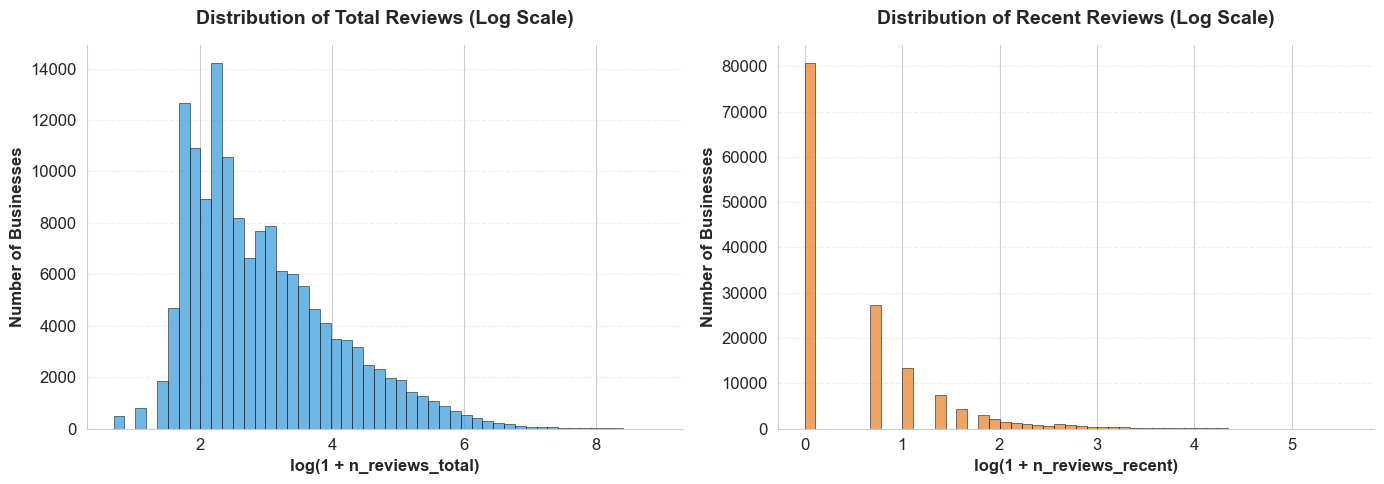


Summary Statistics Table
                n_reviews_total n_reviews_recent
Median                     14.0              0.0
IQR                        28.0              2.0
90th percentile            93.0              5.0
99th percentile           455.0             23.0

Caption: Review activity is heavy-tailed; most businesses have few pre-T reviews,
         but a small fraction have very high volume.


In [47]:
# Create histograms with log scale
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram for n_reviews_total (log scale)
ax1 = axes[0]
data_total = reviews_features['n_reviews_total'].values
data_total_log = np.log1p(data_total)  # log(1+x) to handle zeros

ax1.hist(data_total_log, bins=50, color='#3498db', alpha=0.7, edgecolor='black', linewidth=0.5)
ax1.set_xlabel('log(1 + n_reviews_total)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Businesses', fontsize=12, fontweight='bold')
ax1.set_title('Distribution of Total Reviews (Log Scale)', fontsize=14, fontweight='bold', pad=15)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Histogram for n_reviews_recent (log scale)
ax2 = axes[1]
data_recent = reviews_features['n_reviews_recent'].values
data_recent_log = np.log1p(data_recent)  # log(1+x) to handle zeros

ax2.hist(data_recent_log, bins=50, color='#e67e22', alpha=0.7, edgecolor='black', linewidth=0.5)
ax2.set_xlabel('log(1 + n_reviews_recent)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Businesses', fontsize=12, fontweight='bold')
ax2.set_title('Distribution of Recent Reviews (Log Scale)', fontsize=14, fontweight='bold', pad=15)
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# Summary statistics table
print("\n" + "="*70)
print("Summary Statistics Table")
print("="*70)

# Calculate statistics for n_reviews_total
median_total = np.median(data_total)
q25_total = np.percentile(data_total, 25)
q75_total = np.percentile(data_total, 75)
iqr_total = q75_total - q25_total
p90_total = np.percentile(data_total, 90)
p99_total = np.percentile(data_total, 99)

# Calculate statistics for n_reviews_recent
median_recent = np.median(data_recent)
q25_recent = np.percentile(data_recent, 25)
q75_recent = np.percentile(data_recent, 75)
iqr_recent = q75_recent - q25_recent
p90_recent = np.percentile(data_recent, 90)
p99_recent = np.percentile(data_recent, 99)

# Create summary table
summary_table = pd.DataFrame({
    'n_reviews_total': {
        'Median': f'{median_total:.1f}',
        'IQR': f'{iqr_total:.1f}',
        '90th percentile': f'{p90_total:.1f}',
        '99th percentile': f'{p99_total:.1f}'
    },
    'n_reviews_recent': {
        'Median': f'{median_recent:.1f}',
        'IQR': f'{iqr_recent:.1f}',
        '90th percentile': f'{p90_recent:.1f}',
        '99th percentile': f'{p99_recent:.1f}'
    }
})

print(summary_table.to_string())
print("\nCaption: Review activity is heavy-tailed; most businesses have few pre-T reviews,")
print("         but a small fraction have very high volume.")
print("="*70)


In [48]:
# Load business data to get is_open labels
business_file = "yelp_academic_dataset_business.json"
businesses = []
with open(business_file, 'r', encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        if line:
            try:
                businesses.append(json.loads(line))
            except json.JSONDecodeError:
                continue

business_df = pd.DataFrame(businesses)
print(f"Loaded {len(business_df):,} businesses")

# Create closed label (closed = 1 if is_open = 0)
business_df['closed'] = (business_df['is_open'] == 0).astype(int)

# Verify reviews_features has the required columns before merge
print(f"\nColumns in reviews_features before merge: {list(reviews_features.columns)}")
assert 'avg_review_stars' in reviews_features.columns, "avg_review_stars missing in reviews_features!"
assert 'std_review_stars' in reviews_features.columns, "std_review_stars missing in reviews_features!"

# Merge review features with business data
business_small = business_df[['business_id', 'is_open', 'closed']].set_index('business_id')
df_merged = business_small.join(reviews_features, how='inner')

# Verify all columns are present after merge
print(f"\nColumns in df_merged after merge: {list(df_merged.columns)}")
assert 'avg_review_stars' in df_merged.columns, "avg_review_stars missing after merge!"
assert 'std_review_stars' in df_merged.columns, "std_review_stars missing after merge!"

print(f"\nBusinesses with reviews and labels: {len(df_merged):,}")
print(f"Closed businesses: {(df_merged['closed'] == 1).sum():,}")
print(f"Open businesses: {(df_merged['closed'] == 0).sum():,}")

Loaded 150,346 businesses

Columns in reviews_features before merge: ['n_reviews_total', 'avg_review_stars', 'std_review_stars', 'avg_review_length', 'last_review_date', 'n_reviews_recent']

Columns in df_merged after merge: ['is_open', 'closed', 'n_reviews_total', 'avg_review_stars', 'std_review_stars', 'avg_review_length', 'last_review_date', 'n_reviews_recent']

Businesses with reviews and labels: 148,035
Closed businesses: 30,602
Open businesses: 117,433


/var/folders/kc/ks5tzk816357yl20z1vqbm980000gn/T/ipykernel_75632/1032539744.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/kc/ks5tzk816357yl20z1vqbm980000gn/T/ipykernel_75632/1032539744.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


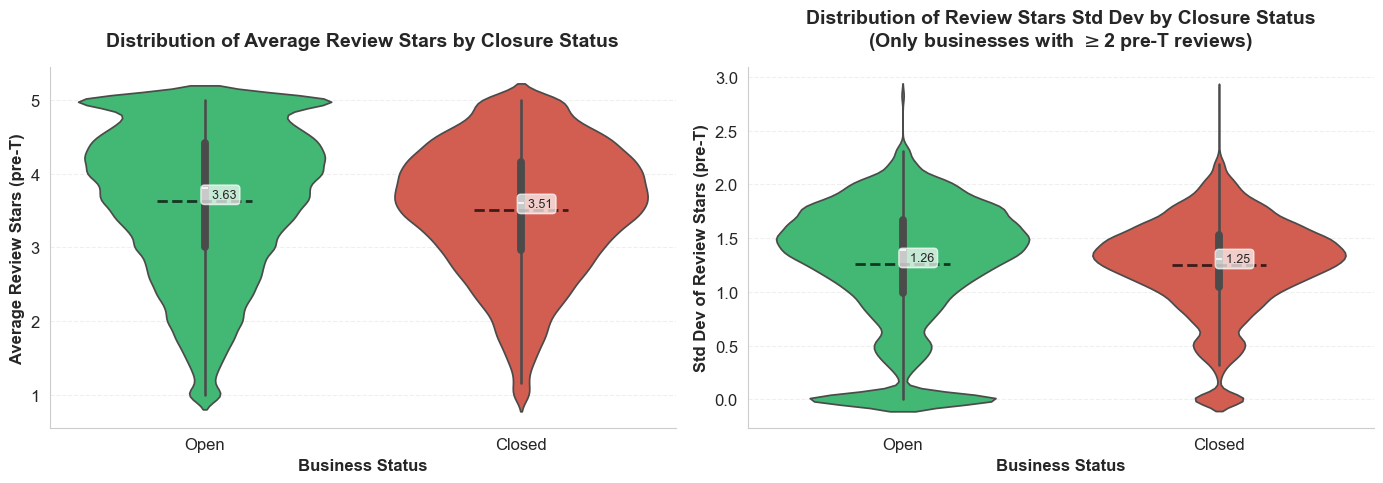


Cohort note: avg_review_stars is computed for businesses with ≥1 pre-T review;
            std_review_stars is shown only for businesses with ≥2 pre-T reviews.
Caption: Open businesses have slightly higher pre-T average ratings,
                    while dispersion differences are assessed on the ≥2-review cohort.


In [51]:
# Create boxplot/violin plots of rating signals by closure status
# Check if required columns exist
required_cols = ['avg_review_stars', 'std_review_stars', 'closed', 'n_reviews_total']
missing = [c for c in required_cols if c not in df_merged.columns]
if missing:
    print(f"ERROR: Missing required columns: {missing}")
    print("Please re-run the feature construction cells to compute these features.")
    print(f"Available columns in df_merged: {list(df_merged.columns)}")
else:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # -------------------------
    # IMPORTANT FIX:
    # std_review_stars is only meaningful when a business has >= 2 pre-T reviews.
    # So we plot avg_review_stars on the full (review-observed) cohort,
    # but restrict the std plot to n_reviews_total >= 2.
    # -------------------------
    # Avg-stars plot cohort: businesses with defined avg_review_stars
    df_plot_avg = df_merged[df_merged['avg_review_stars'].notna()].copy()

    # Std-dev plot cohort: businesses with defined std AND at least 2 pre-T reviews
    df_plot_std = df_merged[
        df_merged['avg_review_stars'].notna() &
        df_merged['std_review_stars'].notna() &
        (df_merged['n_reviews_total'] >= 2)
    ].copy()

    # Create label for plotting
    df_plot_avg['Status'] = df_plot_avg['closed'].map({0: 'Open', 1: 'Closed'})
    df_plot_std['Status'] = df_plot_std['closed'].map({0: 'Open', 1: 'Closed'})

    # avg_review_stars
    ax1 = axes[0]
    sns.violinplot(
        data=df_plot_avg, x='Status', y='avg_review_stars', ax=ax1,
        order=['Open', 'Closed'], palette=['#2ecc71', '#e74c3c'], inner='box'
    )
    ax1.set_xlabel('Business Status', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Average Review Stars (pre-T)', fontsize=12, fontweight='bold')
    ax1.set_title('Distribution of Average Review Stars by Closure Status', fontsize=14, fontweight='bold', pad=15)
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    # Add mean markers for avg_review_stars
    for idx, status in enumerate(['Open', 'Closed']):
        mean_val = df_plot_avg[df_plot_avg['Status'] == status]['avg_review_stars'].mean()
        ax1.plot([idx - 0.15, idx + 0.15], [mean_val, mean_val],
                 color='black', linestyle='--', alpha=0.7, linewidth=2)
        ax1.text(idx, mean_val, f'  {mean_val:.2f}',
                 ha='left', va='bottom', fontsize=9,
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

    # std_review_stars (restricted to n_reviews_total >= 2)
    ax2 = axes[1]
    sns.violinplot(
        data=df_plot_std, x='Status', y='std_review_stars', ax=ax2,
        order=['Open', 'Closed'], palette=['#2ecc71', '#e74c3c'], inner='box'
    )
    ax2.set_xlabel('Business Status', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Std Dev of Review Stars (pre-T)', fontsize=12, fontweight='bold')
    ax2.set_title('Distribution of Review Stars Std Dev by Closure Status\n(Only businesses with $\geq$2 pre-T reviews)',
                  fontsize=14, fontweight='bold', pad=15)
    ax2.grid(axis='y', alpha=0.3, linestyle='--')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    # Add mean markers for std_review_stars
    for idx, status in enumerate(['Open', 'Closed']):
        mean_val = df_plot_std[df_plot_std['Status'] == status]['std_review_stars'].mean()
        ax2.plot([idx - 0.15, idx + 0.15], [mean_val, mean_val],
                 color='black', linestyle='--', alpha=0.7, linewidth=2)
        ax2.text(idx, mean_val, f'  {mean_val:.2f}',
                 ha='left', va='bottom', fontsize=9,
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

    plt.tight_layout()
    plt.show()

    print("\n" + "="*70)
    print("Cohort note: avg_review_stars is computed for businesses with ≥1 pre-T review;")
    print("            std_review_stars is shown only for businesses with ≥2 pre-T reviews.")
    print("Caption: Open businesses have slightly higher pre-T average ratings,")
    print("                    while dispersion differences are assessed on the ≥2-review cohort.")
    print("="*70)

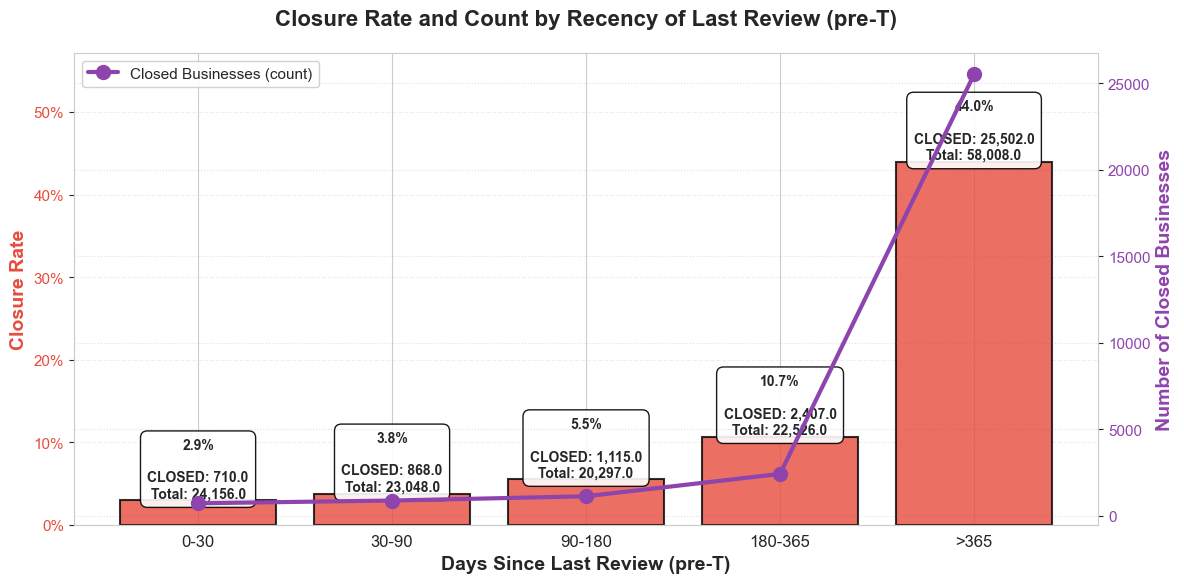


Closure Rate by Days Since Last Review (pre-T)
          total_businesses  closed_count  closure_rate
days_bin                                              
0-30                 24156           710      0.029392
30-90                23048           868      0.037661
90-180               20297          1115      0.054934
180-365              22526          2407      0.106854
>365                 58008         25502      0.439629

Caption: Businesses with less recent pre-T activity have sharply higher closure rates.


In [ ]:
# Recency signal: time since last review before T vs closure rate
# Compute days_since_last_review = (T - last_review_date).days
if 'last_review_date' not in df_merged.columns:
    print("ERROR: last_review_date column not found.")
    print("Please re-run cell 5 to compute this feature.")
else:
    # Calculate days since last review
    df_merged['days_since_last_review'] = (cutoff_T - df_merged['last_review_date']).dt.days

# Keep only valid recency values (should be >= 0 if last_review_date is truly pre-T)
    df_rec = df_merged[df_merged['days_since_last_review'].notna()].copy()

# enforce nonnegative
    neg = (df_rec['days_since_last_review'] < 0).sum()
    if neg > 0:
        print(f"WARNING: {neg} businesses have last_review_date after T (negative recency). "
          f"These will be dropped for the recency plot/table.")
        df_rec = df_rec[df_rec['days_since_last_review'] >= 0].copy()

# Define bins and include 0 in the first bin
    bins = [0, 30, 90, 180, 365, float('inf')]
    bin_labels = ['0-30', '30-90', '90-180', '180-365', '>365']
    df_rec['days_bin'] = pd.cut(
    df_rec['days_since_last_review'],
    bins=bins,
    labels=bin_labels,
    include_lowest=True,   # includes 0
    right=True             # keeps 30 in 0-30, 90 in 30-90, etc.
    )

# Now compute closure-by-bin on df_rec 
    closure_by_bin = df_rec.groupby('days_bin', observed=True).agg(
        total_businesses=('closed', 'count'),
        closed_count=('closed', 'sum')
    )
    closure_by_bin['closure_rate'] = closure_by_bin['closed_count'] / closure_by_bin['total_businesses']

    # Create bar chart with dual focus on rate and closed count
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Primary axis: closure rate (bars)
    bars = ax1.bar(closure_by_bin.index.astype(str), closure_by_bin['closure_rate'], 
                   color='#e74c3c', alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Secondary axis: number of closed businesses 
    ax2 = ax1.twinx()
    line = ax2.plot(closure_by_bin.index.astype(str), closure_by_bin['closed_count'], 
                    color='#8e44ad', marker='o', markersize=10, linewidth=3, 
                    label='Closed Businesses (count)', zorder=10)
    ax2.set_ylabel('Number of Closed Businesses', fontsize=14, fontweight='bold', color='#8e44ad')
    ax2.tick_params(axis='y', labelcolor='#8e44ad', labelsize=11)
    ax2.grid(axis='y', alpha=0.2, linestyle=':', color='#8e44ad')
    
    # Add value labels on top of bars (enhanced to show closed count prominently)
    for i, (bar, rate) in enumerate(zip(bars, closure_by_bin['closure_rate'])):
        height = bar.get_height()
        closed_count = closure_by_bin.iloc[i]['closed_count']
        total_count = closure_by_bin.iloc[i]['total_businesses']
        
        # Main label with closed count prominently displayed
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{rate:.1%}\n\nCLOSED: {closed_count:,}\nTotal: {total_count:,}',
                ha='center', va='bottom', fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9, edgecolor='black'))
    
    # Customize primary axis
    ax1.set_ylabel('Closure Rate', fontsize=14, fontweight='bold', color='#e74c3c')
    ax1.set_xlabel('Days Since Last Review (pre-T)', fontsize=14, fontweight='bold')
    ax1.set_title('Closure Rate and Count by Recency of Last Review (pre-T)', 
                  fontsize=16, fontweight='bold', pad=20)
    ax1.set_ylim(0, max(closure_by_bin['closure_rate']) * 1.3)
    ax1.tick_params(axis='y', labelcolor='#e74c3c', labelsize=11)
    
    # Format y-axis as percentage
    from matplotlib.ticker import PercentFormatter
    ax1.yaxis.set_major_formatter(PercentFormatter(1))
    
    # Add grid for better readability
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Remove top and right spines
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    
    # Add legend
    ax2.legend(loc='upper left', fontsize=11, framealpha=0.9)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*70)
    print("Closure Rate by Days Since Last Review (pre-T)")
    print("="*70)
    print(closure_by_bin[['total_businesses', 'closed_count', 'closure_rate']].to_string())
    print("\n" + "="*70)
    print("Caption: Businesses with less recent pre-T activity have sharply higher closure rates.")
    print("="*70)

# Business Closure (Classification) Code

In [ ]:

# === Cell 1: Imports & config ===
from __future__ import annotations

import json
from pathlib import Path
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, confusion_matrix,
    roc_auc_score, average_precision_score, mean_squared_error, r2_score,
)

RANDOM_STATE = 301


In [2]:

# === Cell 2: JSON-lines loader ===
def parse_yelp_json_lines(path: str | Path, n_rows: Optional[int] = None, verbose: bool = True) -> pd.DataFrame:
    """Load a Yelp JSON-lines file (e.g., business.json, review.json)."""
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(f"File not found: {path}")
    records = []
    with path.open("r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            try:
                records.append(json.loads(line))
            except json.JSONDecodeError:
                continue
            if n_rows is not None and len(records) >= n_rows:
                break
            if verbose and (i + 1) % 100_000 == 0:
                print(f"  Parsed {i + 1:,} lines so far.")
    if not records:
        raise ValueError("No valid JSON records were loaded from the file.")
    df = pd.DataFrame.from_records(records)
    if verbose:
        print(f"Finished reading. Loaded {len(df):,} records from {path.name}.")
    return df


In [ ]:

# === Cell 3: Feature engineering (cutoff, recent window, aggregates) ===
def build_business_review_features(business_df: pd.DataFrame,
                                   review_df: pd.DataFrame,
                                   cutoff_date: str | pd.Timestamp,
                                   recent_window_days: int = 180) -> pd.DataFrame:
    """Create features with strict cutoff-time enforcement to avoid leakage."""
    # Ensure proper datetime for reviews and enforce cutoff
    if "date" in review_df.columns:
        review_df = review_df.copy()
        review_df["date"] = pd.to_datetime(review_df["date"], errors="coerce")
        review_df = review_df[review_df["date"].notna()]
    cutoff = pd.to_datetime(cutoff_date)
    review_df = review_df[review_df["date"] <= cutoff].copy()

    # Simple text proxy
    if "text" in review_df.columns:
        review_df["review_length"] = review_df["text"].astype(str).str.len()
    else:
        review_df["review_length"] = np.nan

    # All-history aggregates up to T
    review_agg = (
        review_df.groupby("business_id")
        .agg(
            n_reviews_total=("review_id", "count"),
            avg_review_stars=("stars", "mean"),
            std_review_stars=("stars", "std"),
            avg_review_length=("review_length", "mean"),
            last_review_date=("date", "max"),
        )
    )
    if "n_reviews_total" in review_agg.columns:
        review_agg["n_reviews_total"] = review_agg["n_reviews_total"].astype("int32")
    review_agg["std_review_stars"] = review_agg["std_review_stars"].fillna(0.0)

    # Recent window aggregates
    window_start = cutoff - pd.Timedelta(days=recent_window_days)
    mask_recent = (review_df["date"] >= window_start) & (review_df["date"] <= cutoff)
    review_recent_agg = (
        review_df[mask_recent].groupby("business_id")
        .agg(
            n_reviews_recent=("review_id", "count"),
            avg_stars_recent=("stars", "mean"),
        )
    )

    # Vote totals up to T
    vote_totals = (
        review_df.groupby("business_id")
        .agg(
           n_useful_total=("useful","sum"),
            n_funny_total=("funny","sum"),
            n_cool_total=("cool","sum"),
        )
    )

    # Vote totals in the recent window [T - recent_window_days, T]
    vote_recent = (
        review_df[mask_recent].groupby("business_id")
         .agg(
            n_useful_recent=("useful","sum"),
            n_funny_recent=("funny","sum"),
            n_cool_recent=("cool","sum"),
        )
    )

    # Join into the review feature block before merging with business
    reviews_features = review_agg.join(review_recent_agg, how="left")
    reviews_features = reviews_features.join(vote_totals, how="left")
    reviews_features = reviews_features.join(vote_recent, how="left")

    # Fill NaNs produced by businesses with zero reviews in a window
    for col in [
     "n_useful_total","n_funny_total","n_cool_total",
     "n_useful_recent","n_funny_recent","n_cool_recent"
    ]:
        if col in reviews_features.columns:
            reviews_features[col] = reviews_features[col].fillna(0).astype("int32")


    # Merge aggregates
    reviews_features = review_agg.join(review_recent_agg, how="left")
    reviews_features["n_reviews_recent"] = reviews_features["n_reviews_recent"].fillna(0).astype("int32")
    reviews_features["avg_stars_recent"] = reviews_features["avg_stars_recent"].fillna(
        reviews_features["avg_review_stars"]
    )

    # Prepare business frame and label
    business_df = business_df.copy()
    if "is_open" not in business_df.columns:
        raise ValueError("business_df must contain 'is_open'.")
    business_df["closed"] = (business_df["is_open"] == 0).astype(int)
    if "categories" in business_df.columns:
        business_df["primary_category"] = (
            business_df["categories"].astype(str).str.split(",").str[0].str.strip()
        )
    else:
        business_df["primary_category"] = np.nan

    keep_cols = [c for c in [
        "business_id","is_open","closed","city","state","latitude","longitude", "primary_category"]
        if c in business_df.columns]
    business_small = business_df[keep_cols].set_index("business_id")

    # Merge engineered review features
    df = business_small.join(reviews_features, how="left")
    # Fill sensible defaults for businesses with 0 reviews <= T
    defaults = {
        "n_reviews_total": 0,
        "avg_review_stars": np.nan,
        "std_review_stars": 0.0,
        "avg_review_length": np.nan,
        "n_reviews_recent": 0,
        "avg_stars_recent": np.nan,
        "n_useful_total": 0,
        "n_funny_total": 0,
        "n_cool_total": 0,
        "n_useful_recent": 0,
        "n_funny_recent": 0,
        "n_cool_recent": 0,
    }
    for col, default in defaults.items():
        if col in df.columns:
            if isinstance(default, int):
                df[col] = df[col].fillna(default).astype("int32")
            else:
                df[col] = df[col].fillna(default)

    return df.reset_index()


In [5]:

# === Cell 4: Dataset prep and feature groups ===
def prepare_datasets(df: pd.DataFrame):
    if "closed" not in df.columns:
        raise ValueError("Expected 'closed' in dataframe.")
    y_clf = df["closed"].astype(int)
    y_reg = df["n_reviews_total"] if "n_reviews_total" in df.columns else None

    numeric_features = [c for c in [
        "latitude","longitude",
        "n_reviews_total","avg_review_stars","std_review_stars",
        "avg_review_length","n_reviews_recent","avg_stars_recent",
        "n_useful_total","n_funny_total","n_cool_total",
        "n_useful_recent","n_funny_recent","n_cool_recent",
        # NEW tip features
        "tip_count_total","avg_tip_len_total","recent_tip_count","avg_tip_len_recent",
         # NEW check-in features
        "n_checkins_prior","n_checkins_recent"
    ] if c in df.columns]
    categorical_features = [c for c in ["city","state","primary_category"] if c in df.columns]

    X = df[numeric_features + categorical_features].copy()
    return X, y_clf, y_reg, numeric_features, categorical_features


def build_feature_groups(numeric_features: List[str], categorical_features: List[str]) -> Dict[str, Dict[str, List[str]]]:
    def inter(existing, candidates):
        s = set(existing)
        return [c for c in candidates if c in s]
    return {
        "GEO": {
            "num": inter(numeric_features, ["latitude","longitude"]),
            "cat": inter(categorical_features, ["city","state"]),
        },
        "BUSINESS": {
            # IMPORTANT: keep leakage-prone business numerics empty
            "num": [],
            "cat": inter(categorical_features, ["primary_category"]),
        },
        "REVIEW": {
            # Use ALL pre-T review aggregates + tips + check-ins
            "num": inter(numeric_features, [
                # review history (≤ T)
                "n_reviews_total","avg_review_stars","std_review_stars","avg_review_length",
                # recent window
                "n_reviews_recent","avg_stars_recent",
                # votes (history + recent)
                "n_useful_total","n_funny_total","n_cool_total",
                "n_useful_recent","n_funny_recent","n_cool_recent",
                # tips (history + recent)
                "tip_count_total","avg_tip_len_total","recent_tip_count","avg_tip_len_recent",
                # check-ins (history + recent)
                "n_checkins_prior","n_checkins_recent",
            ]),
            "cat": [],
        },
        "ALL": {
            "num": list(numeric_features),
            "cat": list(categorical_features),
        },
    }



In [6]:

# === Cell 5: Metrics helper (ACC/PR/REC/F1/ROC-AUC/PR-AUC + CM) ===
def evaluate_binary_classifier(y_true, y_proba, y_pred) -> Dict[str, float]:
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    roc = np.nan
    ap = np.nan
    if y_proba is not None:
        try:
            roc = roc_auc_score(y_true, y_proba)
        except Exception:
            pass
        try:
            ap = average_precision_score(y_true, y_proba)
        except Exception:
            pass
    return {"accuracy": float(acc), "precision": float(prec), "recall": float(rec),
            "f1": float(f1), "roc_auc": float(roc), "pr_auc": float(ap)}


def print_confusion(name: str, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print(f"{name} — Confusion Matrix [[TN, FP], [FN, TP]]:")
    print(cm)


In [7]:

# === Cell 6: Train/eval per feature group (LogReg L2, RidgeCls + calib, Tree, RF; 5-fold CV) ===
def run_classification_for_feature_group(X: pd.DataFrame, y: pd.Series,
                                         numeric_features: List[str], categorical_features: List[str],
                                         group_name: str, random_state: int = RANDOM_STATE):
    Xg = X[numeric_features + categorical_features].copy()

    X_train, X_test, y_train, y_test = train_test_split(
        Xg, y, test_size=0.2, random_state=random_state, stratify=y
    )

    numeric_transformer = Pipeline([("imputer", SimpleImputer(strategy="median")),
                                   ("scaler", StandardScaler())])
    categorical_transformer = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                                        ("onehot", OneHotEncoder(handle_unknown="ignore"))])
    preprocessor = ColumnTransformer([("num", numeric_transformer, numeric_features),
                                      ("cat", categorical_transformer, categorical_features)])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    results = {}

    # Logistic Regression (explicit L2 → ridge-penalized logistic)
    logreg = Pipeline([("pre", preprocessor),
                       ("model", LogisticRegression(penalty="l2", max_iter=1000, class_weight="balanced"))])
    gs_logreg = GridSearchCV(logreg, {"model__C": [0.1, 1.0, 10.0]}, scoring="roc_auc", cv=cv, n_jobs=-1, refit=True)
    gs_logreg.fit(X_train, y_train)
    y_proba_lr = gs_logreg.predict_proba(X_test)[:, 1]
    y_pred_lr = (y_proba_lr >= 0.5).astype(int)
    results["logistic_l2_ridge"] = evaluate_binary_classifier(y_test, y_proba_lr, y_pred_lr)
    print_confusion("Logistic L2 (ridge-penalized)", y_test, y_pred_lr)

    # RidgeClassifier (least-squares) + calibration for probabilities
    ridge_clf = Pipeline([("pre", preprocessor),
                          ("model", RidgeClassifier())])
    gs_ridge_clf = GridSearchCV(ridge_clf, {"model__alpha": [0.01, 0.1, 1.0, 10.0]},
                                scoring="roc_auc", cv=cv, n_jobs=-1, refit=True)
    gs_ridge_clf.fit(X_train, y_train)
    cal_ridge = CalibratedClassifierCV(gs_ridge_clf.best_estimator_, method="sigmoid", cv=3)
    cal_ridge.fit(X_train, y_train)
    y_proba_ridge = cal_ridge.predict_proba(X_test)[:, 1]
    y_pred_ridge  = (y_proba_ridge >= 0.5).astype(int)
    results["ridge_classifier_calibrated"] = evaluate_binary_classifier(y_test, y_proba_ridge, y_pred_ridge)
    print_confusion("RidgeClassifier (calibrated)", y_test, y_pred_ridge)

    # Decision Tree
    tree = Pipeline([("pre", preprocessor),
                     ("model", DecisionTreeClassifier(random_state=random_state, class_weight="balanced"))])
    gs_tree = GridSearchCV(tree,
                           {"model__max_depth": [3, 5, 10, None], "model__min_samples_leaf": [1, 5, 10]},
                           scoring="roc_auc", cv=cv, n_jobs=-1, refit=True)
    gs_tree.fit(X_train, y_train)
    y_proba_dt = gs_tree.predict_proba(X_test)[:, 1]
    y_pred_dt = (y_proba_dt >= 0.5).astype(int)
    results["decision_tree"] = evaluate_binary_classifier(y_test, y_proba_dt, y_pred_dt)
    print_confusion("Decision Tree", y_test, y_pred_dt)

    # Random Forest
    rf = Pipeline([("pre", preprocessor),
                   ("model", RandomForestClassifier(random_state=random_state, class_weight="balanced_subsample"))])
    gs_rf = GridSearchCV(rf,
                         {"model__n_estimators": [100, 300],
                          "model__max_depth": [None, 10],
                          "model__min_samples_leaf": [1, 5],
                          "model__max_features": ["sqrt", "log2"]},
                         scoring="roc_auc", cv=cv, n_jobs=-1, refit=True)
    gs_rf.fit(X_train, y_train)
    y_proba_rf = gs_rf.predict_proba(X_test)[:, 1]
    y_pred_rf = (y_proba_rf >= 0.5).astype(int)
    results["random_forest"] = evaluate_binary_classifier(y_test, y_proba_rf, y_pred_rf)
    print_confusion("Random Forest", y_test, y_pred_rf)

    print(f"\n=== {group_name} ===")
    for m, d in results.items():
        print(f"{m:27s} acc={d['accuracy']:.3f} f1={d['f1']:.3f} roc_auc={d['roc_auc']:.3f} pr_auc={d['pr_auc']:.3f}")
    return results


In [8]:

# === Cell 7: Wrapper across feature groups ===
def run_feature_group_classification_experiments(X, y, numeric_all, categorical_all, random_state: int = RANDOM_STATE):
    groups = build_feature_groups(numeric_all, categorical_all)
    all_results = {}
    for name, grp in groups.items():
        num_feats, cat_feats = grp["num"], grp["cat"]
        if not num_feats and not cat_feats:
            print(f"Skipping {name}: no features present.")
            continue
        print(f"\nRunning group: {name}")
        all_results[name] = run_classification_for_feature_group(
            X, y, num_feats, cat_feats, group_name=name, random_state=random_state
        )
    return all_results


In [9]:

# === Cell 8: Optional regression models (Custom Path) ===
def run_regression_models(X, y_reg, numeric_features, categorical_features, random_state: int = RANDOM_STATE):
    if y_reg is None:
        print("No regression target provided; skipping regression.")
        return {}

    X_train, X_test, y_train, y_test = train_test_split(
        X[numeric_features + categorical_features], y_reg, test_size=0.2, random_state=random_state
    )

    numeric_transformer = Pipeline([("imputer", SimpleImputer(strategy="median")),
                                   ("scaler", StandardScaler())])
    categorical_transformer = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                                        ("onehot", OneHotEncoder(handle_unknown="ignore"))])
    preprocessor = ColumnTransformer([("num", numeric_transformer, numeric_features),
                                      ("cat", categorical_transformer, categorical_features)])

    ridge = Pipeline([("pre", preprocessor), ("model", Ridge())])
    gs_ridge = GridSearchCV(ridge, {"model__alpha": [0.01, 0.1, 1.0, 10.0]},
                            scoring="neg_mean_squared_error", cv=5, n_jobs=-1)
    gs_ridge.fit(X_train, y_train)
    y_pred_ridge = gs_ridge.predict(X_test)
    ridge_metrics = {"rmse": float(np.sqrt(mean_squared_error(y_test, y_pred_ridge))),
                     "r2": float(r2_score(y_test, y_pred_ridge))}

    rfr = Pipeline([("pre", preprocessor), ("model", RandomForestRegressor(random_state=random_state))])
    gs_rfr = GridSearchCV(rfr,
                          {"model__n_estimators": [200, 400],
                           "model__max_depth": [None, 12],
                           "model__min_samples_leaf": [1, 5]},
                          scoring="neg_mean_squared_error", cv=5, n_jobs=-1)
    gs_rfr.fit(X_train, y_train)
    y_pred_rfr = gs_rfr.predict(X_test)
    rfr_metrics = {"rmse": float(np.sqrt(mean_squared_error(y_test, y_pred_rfr))),
                   "r2": float(r2_score(y_test, y_pred_rfr))}

    print("\nRegression results (test):")
    print(f"Ridge         RMSE={ridge_metrics['rmse']:.3f} R2={ridge_metrics['r2']:.3f}")
    print(f"RandomForest  RMSE={rfr_metrics['rmse']:.3f} R2={rfr_metrics['r2']:.3f}")
    return {"ridge": ridge_metrics, "random_forest_reg": rfr_metrics}


In [ ]:

# === Cell 9: Config ===
BUSINESS_JSON = "yelp_academic_dataset_business.json"
REVIEW_JSON   = "yelp_academic_dataset_review.json"

# Manual cutoff (kept for reproducibility)
CUTOFF_DATE = "2016-12-31"
RECENT_WINDOW_DAYS = 180

# Optional row limits 
LIMIT_BUSINESS_ROWS = None
LIMIT_REVIEW_ROWS   = None


In [ ]:

# === Cell 9A: Calendar-based cutoff function + usage ===
def compute_cutoff_date_calendar(review_df: pd.DataFrame,
                                 years_before_end: int = 1,
                                 verbose: bool = True) -> pd.Timestamp:
    """Compute a calendar-based cutoff date T (Dec 31 of a chosen year before max review date)."""
    df = review_df.copy()
    if "date" not in df.columns:
        raise ValueError("review_df must contain a 'date' column from review.json")
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df = df.dropna(subset=["date"])

    end_date = df["date"].max()
    end_year = end_date.year
    cutoff_year = end_year - years_before_end

    cutoff_date = pd.Timestamp(year=cutoff_year, month=12, day=31).normalize()

    if verbose:
        print(f"Latest review date in dataset : {end_date.date()}")
        print(f"End year                      : {end_year}")
        print(f"Chosen cutoff year (T's year) : {cutoff_year}")
        print(f"Cutoff date T                 : {cutoff_date.date()}")

        before_T = (df["date"] <= cutoff_date).sum()
        after_T  = (df["date"] > cutoff_date).sum()
        print(f"Reviews ≤ T : {before_T:,}")
        print(f"Reviews > T : {after_T:,}")

    return cutoff_date

# Load review.json just to compute T
print("Loading review.json (for cutoff computation) ...")
_review_for_T = parse_yelp_json_lines(REVIEW_JSON, n_rows=LIMIT_REVIEW_ROWS, verbose=True)
cutoff_T = compute_cutoff_date_calendar(_review_for_T, years_before_end=2, verbose=True)  # adjust years_before_end
print("Chosen cutoff date T:", cutoff_T.date())


Loading review.json (for cutoff computation) ...
  Parsed 100,000 lines so far.
  Parsed 200,000 lines so far.
  Parsed 300,000 lines so far.
  Parsed 400,000 lines so far.
  Parsed 500,000 lines so far.
  Parsed 600,000 lines so far.
  Parsed 700,000 lines so far.
  Parsed 800,000 lines so far.
  Parsed 900,000 lines so far.
  Parsed 1,000,000 lines so far.
  Parsed 1,100,000 lines so far.
  Parsed 1,200,000 lines so far.
  Parsed 1,300,000 lines so far.
  Parsed 1,400,000 lines so far.
  Parsed 1,500,000 lines so far.
  Parsed 1,600,000 lines so far.
  Parsed 1,700,000 lines so far.
  Parsed 1,800,000 lines so far.
  Parsed 1,900,000 lines so far.
  Parsed 2,000,000 lines so far.
  Parsed 2,100,000 lines so far.
  Parsed 2,200,000 lines so far.
  Parsed 2,300,000 lines so far.
  Parsed 2,400,000 lines so far.
  Parsed 2,500,000 lines so far.
  Parsed 2,600,000 lines so far.
  Parsed 2,700,000 lines so far.
  Parsed 2,800,000 lines so far.
  Parsed 2,900,000 lines so far.
  Parsed 3,0

In [12]:

# === Cell 10: Load full data (for modeling) ===
print("Loading business.json ...")
business_df = parse_yelp_json_lines(BUSINESS_JSON, n_rows=LIMIT_BUSINESS_ROWS, verbose=True)

print("Loading review.json ...")
review_df   = parse_yelp_json_lines(REVIEW_JSON, n_rows=LIMIT_REVIEW_ROWS, verbose=True)

print(f"\nBusinesses loaded: {len(business_df):,}")
print(f"Reviews loaded   : {len(review_df):,}")


Loading business.json ...
  Parsed 100,000 lines so far.
Finished reading. Loaded 150,346 records from yelp_academic_dataset_business.json.
Loading review.json ...
  Parsed 100,000 lines so far.
  Parsed 200,000 lines so far.
  Parsed 300,000 lines so far.
  Parsed 400,000 lines so far.
  Parsed 500,000 lines so far.
  Parsed 600,000 lines so far.
  Parsed 700,000 lines so far.
  Parsed 800,000 lines so far.
  Parsed 900,000 lines so far.
  Parsed 1,000,000 lines so far.
  Parsed 1,100,000 lines so far.
  Parsed 1,200,000 lines so far.
  Parsed 1,300,000 lines so far.
  Parsed 1,400,000 lines so far.
  Parsed 1,500,000 lines so far.
  Parsed 1,600,000 lines so far.
  Parsed 1,700,000 lines so far.
  Parsed 1,800,000 lines so far.
  Parsed 1,900,000 lines so far.
  Parsed 2,000,000 lines so far.
  Parsed 2,100,000 lines so far.
  Parsed 2,200,000 lines so far.
  Parsed 2,300,000 lines so far.
  Parsed 2,400,000 lines so far.
  Parsed 2,500,000 lines so far.
  Parsed 2,600,000 lines so f

In [ ]:

# === Cell 11: Build features with cutoff (prefer computed cutoff_T)
#              + drop businesses first-reviewed AFTER T ===

T_effective = cutoff_T if 'cutoff_T' in globals() else pd.to_datetime(CUTOFF_DATE).normalize()

feats_df = build_business_review_features(
    business_df, review_df,
    cutoff_date=T_effective, recent_window_days=RECENT_WINDOW_DAYS
)

# First-review time per business from the full (unfiltered) review_df
review_df["date"] = pd.to_datetime(review_df["date"], errors="coerce")
first_review = review_df.groupby("business_id")["date"].min().dropna()

# Identify & drop businesses whose first review is AFTER T
valid_ids   = first_review.index[first_review <= T_effective]
invalid_ids = first_review.index[first_review >  T_effective]

n_before = len(feats_df)
feats_df = feats_df[feats_df["business_id"].isin(valid_ids)].reset_index(drop=True)
n_after  = len(feats_df)

print(f"Using cutoff date T: {T_effective.date()}")
print(f"Businesses first-reviewed after T (excluded): {len(invalid_ids):,}")
print(f"Businesses kept (first review ≤ T): {n_after:,} (from {n_before:,})")

# Guardrails
assert review_df["date"].max() >= T_effective, "T is after max review date — check years_before_end."
assert feats_df["n_reviews_total"].notna().all(), "Unexpected NaNs in engineered features."
assert feats_df["business_id"].isin(valid_ids).all(), "Found businesses with first review after T."


# Exclude “cold-start” businesses whose first review is after T
excluded = int((feats_df["n_reviews_total"] == 0).sum())
print(f"Excluding businesses with zero reviews ≤ T: {excluded:,}")
feats_df = feats_df[feats_df["n_reviews_total"] > 0].copy()
print(f"Kept businesses with ≥1 review ≤ T: {feats_df.shape[0]:,}")

# ignore, was added for my initial idea, but I got rid of recurrent neural networks
feats_df_gru = feats_df[feats_df["n_reviews_recent"] > 0].copy()
print(f"GRU subset (≥1 review in last {RECENT_WINDOW_DAYS} days): {feats_df_gru.shape[0]:,}")


Using cutoff date T: 2020-12-31
Businesses first-reviewed after T (excluded): 2,311
Businesses kept (first review ≤ T): 148,035 (from 150,346)
Excluding businesses with zero reviews ≤ T: 0
Kept businesses with ≥1 review ≤ T: 148,035
GRU subset (≥1 review in last 180 days): 67,315


In [14]:
# === NEW CELL: Tip features up to T, then join ===
TIP_JSON_PATH = "yelp_academic_dataset_tip.json"

if 'tip_df' not in globals():
    # parse_yelp_json_lines does NOT accept `use_cols`
    tip_df = parse_yelp_json_lines(TIP_JSON_PATH, verbose=True)
    # keep only what we actually need
    keep = [c for c in ["business_id", "date", "text"] if c in tip_df.columns]
    tip_df = tip_df[keep].copy()
    tip_df["date"] = pd.to_datetime(tip_df["date"], errors="coerce")
    tip_df = tip_df.dropna(subset=["date"])

# Enforce cutoff (only tips <= T)
Tstamp = pd.to_datetime(T_effective)
tip_cut = tip_df[tip_df["date"] <= Tstamp].copy()
tip_cut["tip_len"] = tip_cut["text"].astype(str).str.len()

# Recent window [T-RECENT_WINDOW_DAYS, T]
window_start = Tstamp - pd.Timedelta(days=RECENT_WINDOW_DAYS)
tip_recent = tip_cut[(tip_cut["date"] >= window_start)]

tip_agg = tip_cut.groupby("business_id").agg(
    tip_count_total=("date", "count"),
    avg_tip_len_total=("tip_len", "mean"),
)
tip_recent_agg = tip_recent.groupby("business_id").agg(
    recent_tip_count=("date", "count"),
    avg_tip_len_recent=("tip_len", "mean"),
)

tip_feats = tip_agg.join(tip_recent_agg, how="left").fillna({"recent_tip_count": 0})

# Join onto feats_df (one row per business)
feats_df = feats_df.merge(tip_feats, how="left", on="business_id")

# Fill counts with 0, keep means as NaN (imputer will handle later)
for col in ["tip_count_total", "recent_tip_count"]:
    if col in feats_df.columns:
        feats_df[col] = feats_df[col].fillna(0).astype("int32")


  Parsed 100,000 lines so far.
  Parsed 200,000 lines so far.
  Parsed 300,000 lines so far.
  Parsed 400,000 lines so far.
  Parsed 500,000 lines so far.
  Parsed 600,000 lines so far.
  Parsed 700,000 lines so far.
  Parsed 800,000 lines so far.
  Parsed 900,000 lines so far.
Finished reading. Loaded 908,915 records from yelp_academic_dataset_tip.json.


In [ ]:
# === NEW CELL: Check-in features up to T, then join ===
CHECKIN_JSON_PATH = "yelp_academic_dataset_checkin.json"

if 'checkin_df' not in globals():
    checkin_df = parse_yelp_json_lines(CHECKIN_JSON_PATH, verbose=True)
    keep = [c for c in ["business_id", "date"] if c in checkin_df.columns]
    checkin_df = checkin_df[keep].copy()

CHECKIN_DT_FORMAT = "%Y-%m-%d %H:%M:%S"

def _count_checkins_up_to_T(row, T):
    if pd.isna(row["date"]):
        return 0
    times = pd.to_datetime(
        [t.strip() for t in str(row["date"]).split(",")],
        format=CHECKIN_DT_FORMAT,      
        errors="coerce"
    )
    return int((times <= T).sum())

def _count_checkins_recent(row, T, recent_days):
    if pd.isna(row["date"]):
        return 0
    times = pd.to_datetime(
        [t.strip() for t in str(row["date"]).split(",")],
        format=CHECKIN_DT_FORMAT,   
        errors="coerce"
    )
    window_start = T - pd.Timedelta(days=recent_days)
    mask = (times >= window_start) & (times <= T)
    return int(mask.sum())

Tstamp = pd.to_datetime(T_effective)
checkin_df["n_checkins_prior"] = checkin_df.apply(
    _count_checkins_up_to_T, axis=1, args=(Tstamp,)
)
checkin_df["n_checkins_recent"] = checkin_df.apply(
    _count_checkins_recent, axis=1, args=(Tstamp, RECENT_WINDOW_DAYS)
)

chk = checkin_df[["business_id", "n_checkins_prior", "n_checkins_recent"]]

feats_df = feats_df.merge(chk, how="left", on="business_id")
for col in ["n_checkins_prior", "n_checkins_recent"]:
    if col in feats_df.columns:
        feats_df[col] = feats_df[col].fillna(0).astype("int32")


  Parsed 100,000 lines so far.
Finished reading. Loaded 131,930 records from yelp_academic_dataset_checkin.json.


In [16]:

# === Cell 12: Prepare datasets ===
X, y_clf, y_reg, num_feats, cat_feats = prepare_datasets(feats_df)
print("X shape:", X.shape, "| #numeric:", len(num_feats), "| #categorical:", len(cat_feats))
print("Classification target positive rate (closed=1):", float(y_clf.mean()))


X shape: (148035, 17) | #numeric: 14 | #categorical: 3
Classification target positive rate (closed=1): 0.20672138345661498


In [17]:

# === NEW Cell 12.1: Sanity checks (insert this right after Cell 12) ===
assert 'cutoff_T' in globals(), "Cutoff T not computed."
assert 'feats_df' in globals() and len(feats_df) > 0, "feats_df not built."
assert (feats_df['n_reviews_total'] >= 0).all(), "Bad n_reviews_total values."

# leakage: allowed to exist in feats_df, but NOT in numeric_features
leak = {'stars','review_count'} & set(feats_df.columns)
# just a diagnostic, not a failure:
print(f"Raw leakage-like columns present in feats_df (ok to exist but not for modeling): {leak}")

assert 'num_feats' in globals(), "numeric_features (num_feats) not defined yet."
assert not ({'stars','review_count'} & set(num_feats)), "Leakage in numeric_features!"

fg = build_feature_groups(num_feats, cat_feats)
assert fg['BUSINESS']['num'] == [], "BUSINESS.num must be empty (no stars/review_count)."

needed_review_cols = {
    "n_reviews_total","avg_review_stars","std_review_stars","avg_review_length",
    "n_reviews_recent","avg_stars_recent",
    "n_useful_total","n_funny_total","n_cool_total",
    "n_useful_recent","n_funny_recent","n_cool_recent",
    "tip_count_total","avg_tip_len_total","recent_tip_count","avg_tip_len_recent",
    "n_checkins_prior","n_checkins_recent",
} & set(feats_df.columns)

missing_in_group = needed_review_cols - set(fg['REVIEW']['num'])
assert not missing_in_group, f"REVIEW group missing: {missing_in_group}"

Raw leakage-like columns present in feats_df (ok to exist but not for modeling): set()


In [18]:

# === Cell 13: Classification experiments across feature groups ===
print("\nRunning classification experiments across feature groups ...")
all_results = run_feature_group_classification_experiments(X, y_clf, num_feats, cat_feats, random_state=RANDOM_STATE)



Running classification experiments across feature groups ...

Running group: GEO
Logistic L2 (ridge-penalized) — Confusion Matrix [[TN, FP], [FN, TP]]:
[[12676 10811]
 [ 2744  3376]]
RidgeClassifier (calibrated) — Confusion Matrix [[TN, FP], [FN, TP]]:
[[23475    12]
 [ 6117     3]]
Decision Tree — Confusion Matrix [[TN, FP], [FN, TP]]:
[[14477  9010]
 [ 3039  3081]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Random Forest — Confusion Matrix [[TN, FP], [FN, TP]]:
[[18887  4600]
 [ 4048  2072]]

=== GEO ===
logistic_l2_ridge           acc=0.542 f1=0.332 roc_auc=0.569 pr_auc=0.248
ridge_classifier_calibrated acc=0.793 f1=0.001 roc_auc=0.569 pr_auc=0.249
decision_tree               acc=0.593 f1=0.338 roc_auc=0.583 pr_auc=0.272
random_forest               acc=0.708 f1=0.324 roc_auc=0.607 pr_auc=0.301

Running group: BUSINESS
Logistic L2 (ridge-penalized) — Confusion Matrix [[TN, FP], [FN, TP]]:
[[14637  8850]
 [ 1900  4220]]
RidgeClassifier (calibrated) — Confusion Matrix [[TN, FP], [FN, TP]]:
[[23172   315]
 [ 5807   313]]
Decision Tree — Confusion Matrix [[TN, FP], [FN, TP]]:
[[14484  9003]
 [ 1858  4262]]
Random Forest — Confusion Matrix [[TN, FP], [FN, TP]]:
[[14542  8945]
 [ 1875  4245]]

=== BUSINESS ===
logistic_l2_ridge           acc=0.637 f1=0.440 roc_auc=0.704 pr_auc=0.352
ridge_classifier_calibrated acc=0.793 f1=0.093 roc_auc=0.703 pr_auc=0.351
decision_tree               acc=0.633 f

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Random Forest — Confusion Matrix [[TN, FP], [FN, TP]]:
[[19879  3608]
 [ 1827  4293]]

=== REVIEW ===
logistic_l2_ridge           acc=0.643 f1=0.508 roc_auc=0.809 pr_auc=0.509
ridge_classifier_calibrated acc=0.790 f1=0.087 roc_auc=0.712 pr_auc=0.351
decision_tree               acc=0.767 f1=0.590 roc_auc=0.851 pr_auc=0.611
random_forest               acc=0.816 f1=0.612 roc_auc=0.862 pr_auc=0.651

Running group: ALL
Logistic L2 (ridge-penalized) — Confusion Matrix [[TN, FP], [FN, TP]]:
[[17668  5819]
 [ 1443  4677]]
RidgeClassifier (calibrated) — Confusion Matrix [[TN, FP], [FN, TP]]:
[[22647   840]
 [ 4459  1661]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Decision Tree — Confusion Matrix [[TN, FP], [FN, TP]]:
[[17302  6185]
 [ 1035  5085]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Random Forest — Confusion Matrix [[TN, FP], [FN, TP]]:
[[22585   902]
 [ 3197  2923]]

=== ALL ===
logistic_l2_ridge           acc=0.755 f1=0.563 roc_auc=0.843 pr_auc=0.629
ridge_classifier_calibrated acc=0.821 f1=0.385 roc_auc=0.777 pr_auc=0.520
decision_tree               acc=0.756 f1=0.585 roc_auc=0.853 pr_auc=0.613
random_forest               acc=0.862 f1=0.588 roc_auc=0.877 pr_auc=0.705


In [20]:

# === Cell 15: Results summary dict ===
all_results


{'GEO': {'logistic_l2_ridge': {'accuracy': 0.5421690816360996,
   'precision': 0.23796433354479454,
   'recall': 0.5516339869281046,
   'f1': 0.33249618358201605,
   'roc_auc': 0.5692440206806102,
   'pr_auc': 0.24826753655087713},
  'ridge_classifier_calibrated': {'accuracy': 0.7929881446955112,
   'precision': 0.2,
   'recall': 0.0004901960784313725,
   'f1': 0.0009779951100244498,
   'roc_auc': 0.568936090636706,
   'pr_auc': 0.24856956298602634},
  'decision_tree': {'accuracy': 0.5930354308102813,
   'precision': 0.2548176329501282,
   'recall': 0.5034313725490196,
   'f1': 0.3383669210916479,
   'roc_auc': 0.5831305581087688,
   'pr_auc': 0.2719040202610873},
  'random_forest': {'accuracy': 0.7079069139054953,
   'precision': 0.3105515587529976,
   'recall': 0.338562091503268,
   'f1': 0.3239524702939337,
   'roc_auc': 0.607214041504256,
   'pr_auc': 0.3014703128194415}},
 'BUSINESS': {'logistic_l2_ridge': {'accuracy': 0.636910190157733,
   'precision': 0.3228768171384851,
   'rec

In [ ]:
# === Cell 16: L1-logistic (sparse selection) on ALL features ===
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

# Train/valid split
X_tr, X_te, y_tr, y_te = train_test_split(
    X[num_feats + cat_feats], y_clf, test_size=0.2, random_state=RANDOM_STATE, stratify=y_clf
)

# Preprocessor (same as before)
num_tr = Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
cat_tr = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("onehot", OneHotEncoder(handle_unknown="ignore"))])
pre_all = ColumnTransformer([("num", num_tr, num_feats), ("cat", cat_tr, cat_feats)])

# L1 logistic (saga) — encourages exact zeros = hard feature selection
pipe_l1 = Pipeline([
    ("pre", pre_all),
    ("clf", LogisticRegression(penalty="l1", solver="saga",
                               class_weight="balanced", max_iter=4000, verbose=1,))
])

# Small grid over regularization strength
param_l1 = {"clf__C": [0.05, 0.1, 0.5, 1.0]}
gs_l1 = GridSearchCV(pipe_l1, param_l1, scoring="roc_auc", cv=5, n_jobs=-1, refit=True, verbose=2)
gs_l1.fit(X_tr, y_tr)

best_l1 = gs_l1.best_estimator_
pre_fitted = best_l1.named_steps["pre"]
feat_names = pre_fitted.get_feature_names_out()
coef = best_l1.named_steps["clf"].coef_.ravel()

# Selected (non-zero) features
sel_idx = np.flatnonzero(coef != 0)
selected_features = pd.DataFrame({
    "feature": feat_names[sel_idx],
    "coef": coef[sel_idx],
    "abs_coef": np.abs(coef[sel_idx]),
}).sort_values("abs_coef", ascending=False)

print("Best C (L1):", gs_l1.best_params_["clf__C"])
print("Nonzero features selected:", len(selected_features), "of", len(feat_names))
selected_features.head(25)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Epoch 1, change: 1
Epoch 1, change: 1
Epoch 2, change: 0.29767798
Epoch 1, change: 1
Epoch 2, change: 0.29255624
Epoch 1, change: 1
Epoch 3, change: 0.1643864
Epoch 3, change: 0.16549642
Epoch 1, change: 1
Epoch 2, change: 0.26441605
Epoch 4, change: 0.11592283
Epoch 4, change: 0.11765678
Epoch 2, change: 0.29450626
Epoch 2, change: 0.29551903
Epoch 3, change: 0.13999731
Epoch 1, change: 1
Epoch 5, change: 0.089999741
Epoch 3, change: 0.1651588
Epoch 5, change: 0.0891885
Epoch 3, change: 0.16702743
Epoch 4, change: 0.090453252
Epoch 1, change: 1
Epoch 6, change: 0.071569073
Epoch 4, change: 0.11514738
Epoch 6, change: 0.072536813
Epoch 1, change: 1
Epoch 4, change: 0.11606285
Epoch 5, change: 0.072044964
Epoch 2, change: 0.29335766
Epoch 1, change: 1
Epoch 7, change: 0.060063927
Epoch 5, change: 0.086574592
Epoch 7, change: 0.060707335
Epoch 6, change: 0.056935289
Epoch 2, change: 0.29294046
Epoch 5, change: 0.089256063
Epoch 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.9min finished


Epoch 703, change: 0.00032264212
Epoch 1307, change: 0.00010203782
Epoch 1381, change: 0.00013146362
Epoch 1273, change: 0.00011413914
Epoch 1292, change: 0.0001112315
Epoch 260, change: 0.00088647752
Epoch 717, change: 0.00034000373
Epoch 727, change: 0.00031362855
Epoch 711, change: 0.00034415689
Epoch 1308, change: 0.00010194175
Epoch 1382, change: 0.00013150037
Epoch 252, change: 0.00091789302
Epoch 1293, change: 0.00011105602
Epoch 1274, change: 0.00011396842
Epoch 725, change: 0.0003114032
Epoch 1309, change: 0.00010178794
Epoch 704, change: 0.00032215202
Epoch 1383, change: 0.00013152351
Epoch 728, change: 0.00031333116
Epoch 1294, change: 0.0001108816
Epoch 1275, change: 0.00011387135
Epoch 712, change: 0.00034363695
Epoch 718, change: 0.00033945556
Epoch 1310, change: 0.00010169732
Epoch 1384, change: 0.00013151096
Epoch 1295, change: 0.00011077269
Epoch 1276, change: 0.00011371024
Epoch 726, change: 0.00031088968
Epoch 1311, change: 0.00010157071
Epoch 705, change: 0.00032164

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.9min finished


Epoch 734, change: 0.00030604751
Epoch 1290, change: 0.00011178455
Epoch 1310, change: 0.00010860932
Epoch 1400, change: 0.00013171698
Epoch 737, change: 0.00030994114
Epoch 726, change: 0.00033472823
Epoch 713, change: 0.00031797371
Epoch 1291, change: 0.0001116471
Epoch 1311, change: 0.00010851868
Epoch 721, change: 0.00034021444
Epoch 1401, change: 0.00013172681
Epoch 735, change: 0.00030528283
Epoch 1292, change: 0.00011153725
Epoch 1312, change: 0.00010837138
Epoch 1402, change: 0.00013174937
Epoch 727, change: 0.00033408299
Epoch 714, change: 0.00031760459
Epoch 3, change: 0.13880528
Epoch 1313, change: 0.00010822233
Epoch 1403, change: 0.0001317465
Epoch 738, change: 0.00030968257
Epoch 1293, change: 0.00011139538
Epoch 722, change: 0.00033972697
Epoch 736, change: 0.00030485136
Epoch 264, change: 0.00087575229
Epoch 1404, change: 0.00013176907
Epoch 1314, change: 0.00010810253
Epoch 1294, change: 0.00011125393
Epoch 728, change: 0.00033363391
Epoch 715, change: 0.00031706361
Ep

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.1min finished


Epoch 1473, change: 0.00013256679
Epoch 757, change: 0.00032666246
Epoch 748, change: 0.00030201041
Epoch 760, change: 0.00031713723
Epoch 771, change: 0.0002849416
Epoch 1355, change: 0.00010337929
Epoch 774, change: 0.00029656452
Epoch 1474, change: 0.00013254921
Epoch 758, change: 0.0003262441
Epoch 749, change: 0.00030170406
Epoch 1356, change: 0.00010325078
Epoch 761, change: 0.00031662994
Epoch 772, change: 0.00028443226
Epoch 1475, change: 0.00013256028
Epoch 775, change: 0.00029618081
Epoch 1357, change: 0.00010313854
Epoch 268, change: 0.00087271088
Epoch 14, change: 0.025965097
Epoch 759, change: 0.00032594074
Epoch 17, change: 0.013981822
Epoch 1476, change: 0.00013257931
Epoch 750, change: 0.00030125633
Epoch 762, change: 0.00031594394
Epoch 1358, change: 0.0001029939
Epoch 773, change: 0.00028380134
Epoch 277, change: 0.00084353699
Epoch 1477, change: 0.00013256444
Epoch 776, change: 0.00029576627
Epoch 760, change: 0.00032549583
Epoch 1359, change: 0.00010288929
Epoch 147

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.1min finished


Epoch 282, change: 0.00083162023
[CV] END ........................................clf__C=0.05; total time= 3.1min
Epoch 1506, change: 0.00013284847
Epoch 790, change: 0.00029094683
Epoch 774, change: 0.00032038052
Epoch 788, change: 0.00027597945
Epoch 765, change: 0.00029486228
Epoch 1507, change: 0.00013285039
Epoch 6, change: 0.07063791
Epoch 20, change: 0.016305852
Epoch 23, change: 0.0089282449
Epoch 791, change: 0.0002904626
Epoch 777, change: 0.00030872822
Epoch 1508, change: 0.00013288842
Epoch 789, change: 0.00027547008
Epoch 775, change: 0.00032006596
Epoch 766, change: 0.00029453652
Epoch 1509, change: 0.00013287345
Epoch 792, change: 0.00029013759
Epoch 778, change: 0.00030821895
Epoch 1510, change: 0.00013291108
Epoch 776, change: 0.00031981934
Epoch 767, change: 0.00029414246
Epoch 790, change: 0.00027500112
Epoch 274, change: 0.00085688731
Epoch 1511, change: 0.00013291299
Epoch 283, change: 0.00082889113
Epoch 793, change: 0.00028995866
Epoch 779, change: 0.0003079035
E

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.1min finished


Epoch 1319, change: 0.00011281417
Epoch 439, change: 0.00059343175
Epoch 1288, change: 0.00016410005
Epoch 1265, change: 0.00018231814
Epoch 216, change: 0.0010691495
Epoch 1252, change: 0.00017569873
Epoch 222, change: 0.0012850451
Epoch 1320, change: 0.00011267352
Epoch 1265, change: 0.00018832725
Epoch 454, change: 0.00056099432
Epoch 1289, change: 0.00016388314
Epoch 1266, change: 0.00018212044
Epoch 1253, change: 0.00017546408
Epoch 1321, change: 0.00011265538
Epoch 198, change: 0.001173468
Epoch 1266, change: 0.00018814452
Epoch 1290, change: 0.00016372491
Epoch 1267, change: 0.00018190635
Epoch 1254, change: 0.00017526427
Epoch 1322, change: 0.00011256461
Epoch 139, change: 0.0015405954
Epoch 1267, change: 0.00018798563
Epoch 440, change: 0.00059240453
Epoch 1268, change: 0.00018171032
Epoch 1291, change: 0.00016356784
Epoch 1255, change: 0.00017508283
Epoch 1323, change: 0.00011245094
Epoch 223, change: 0.001281277
Epoch 217, change: 0.0010663696
Epoch 455, change: 0.0005601050

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.6min finished


Epoch 1397, change: 0.00015162465
Epoch 263, change: 0.00093138214
Epoch 1411, change: 0.0001572145
Epoch 1408, change: 0.00016258889
Epoch 503, change: 0.00052269449
Epoch 244, change: 0.0010031969
Epoch 1435, change: 0.00013968806
Epoch 1398, change: 0.00015148936
Epoch 1412, change: 0.00015706375
Epoch 1409, change: 0.00016248248
Epoch 1436, change: 0.0001395202
Epoch 172, change: 0.0012131044
Epoch 1399, change: 0.00015136414
Epoch 487, change: 0.00054422794
Epoch 1413, change: 0.00015691367
Epoch 1410, change: 0.00016227153
Epoch 1437, change: 0.00013937839
Epoch 271, change: 0.0010913325
Epoch 1400, change: 0.00015117498
Epoch 264, change: 0.00092874723
Epoch 1414, change: 0.00015672197
Epoch 1411, change: 0.00016216778
Epoch 1438, change: 0.00013925086
Epoch 504, change: 0.00052182317
Epoch 245, change: 0.0009997266
Epoch 1401, change: 0.00015106485
Epoch 1415, change: 0.00015654011
Epoch 1412, change: 0.00016189509
Epoch 1439, change: 0.00013906603
Epoch 33, change: 0.008211206

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.8min finished


Epoch 388, change: 0.00078553616
Epoch 1769, change: 0.00011371571
Epoch 602, change: 0.00045806681
Epoch 1755, change: 0.00010681998
Epoch 112, change: 0.0018350295
Epoch 1780, change: 0.00011454835
Epoch 379, change: 0.00073344321
Epoch 358, change: 0.00070078364
Epoch 253, change: 0.00092616552
Epoch 1770, change: 0.00011359846
Epoch 1781, change: 0.00011446497
Epoch 1756, change: 0.00010672858
Epoch 80, change: 0.0025165174
Epoch 1771, change: 0.00011348176
Epoch 623, change: 0.00044110554
Epoch 1757, change: 0.00010664358
Epoch 1782, change: 0.00011438332
Epoch 1772, change: 0.00011336079
Epoch 389, change: 0.00078410932
Epoch 603, change: 0.00045778171
Epoch 1758, change: 0.0001065302
Epoch 380, change: 0.00073203965
Epoch 359, change: 0.00069886396
Epoch 1783, change: 0.00011424899
Epoch 1773, change: 0.00011326762
Epoch 1759, change: 0.00010642687
Epoch 1784, change: 0.00011421441
Epoch 1774, change: 0.00011318024
Epoch 624, change: 0.00044051399
Epoch 113, change: 0.0018205173

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.0min finished


Epoch 646, change: 0.00042727618
Epoch 412, change: 0.0007502283
Epoch 381, change: 0.00065490184
Epoch 402, change: 0.00070226686
Epoch 1856, change: 0.00010783691
Epoch 1844, change: 0.00010577539
Epoch 96, change: 0.0022757889
Epoch 128, change: 0.0016038662
Epoch 625, change: 0.00044630105
Epoch 1857, change: 0.00010779782
Epoch 269, change: 0.00088107282
Epoch 1845, change: 0.00010567137
Epoch 1858, change: 0.00010766038
Epoch 1846, change: 0.00010559221
Epoch 647, change: 0.00042701516
Epoch 413, change: 0.00074922949
Epoch 382, change: 0.00065262997
Epoch 1859, change: 0.00010761323
Epoch 16, change: 0.021859303
Epoch 403, change: 0.00070111579
Epoch 1847, change: 0.00010547214
Epoch 626, change: 0.0004459069
Epoch 1860, change: 0.00010749895
Epoch 1848, change: 0.0001053495
Epoch 97, change: 0.002267493
Epoch 129, change: 0.0015899094
Epoch 1861, change: 0.00010742374
Epoch 1849, change: 0.00010529336
Epoch 1, change: 1
Epoch 648, change: 0.00042654208
Epoch 270, change: 0.0008

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.2min finished


Epoch 28, change: 0.010328158
Epoch 1918, change: 0.00010408714
Epoch 282, change: 0.00084604601
Epoch 644, change: 0.00043701584
Epoch 400, change: 0.00062429679
Epoch 141, change: 0.0014447042
Epoch 432, change: 0.0007227188
Epoch 1919, change: 0.00010402115
Epoch 421, change: 0.00067763245
Epoch 666, change: 0.00041864066
Epoch 1920, change: 0.00010399398
Epoch 1921, change: 0.00010393254
Epoch 110, change: 0.0021002652
Epoch 645, change: 0.00043641727
Epoch 13, change: 0.027516541
Epoch 401, change: 0.0006232241
Epoch 433, change: 0.00072101995
Epoch 1922, change: 0.00010388117
Epoch 29, change: 0.0098342628
Epoch 283, change: 0.00084383965
Epoch 422, change: 0.00067618927
Epoch 667, change: 0.00041813037
Epoch 1923, change: 0.00010385679
Epoch 142, change: 0.0014328942
Epoch 1924, change: 0.00010380366
Epoch 646, change: 0.00043593995
Epoch 402, change: 0.00062206081
Epoch 434, change: 0.00071998658
Epoch 1925, change: 0.00010376618
Epoch 111, change: 0.0020841252
Epoch 1926, chan

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.5min finished


Epoch 32, change: 0.0081582697
Epoch 429, change: 0.00059529642
Epoch 130, change: 0.0018753414
Epoch 696, change: 0.00040590024
Epoch 450, change: 0.00064240221
Epoch 463, change: 0.00068229911
Epoch 674, change: 0.00042228632
Epoch 303, change: 0.00079353531
Epoch 162, change: 0.0012316415
Epoch 430, change: 0.00059432613
Epoch 49, change: 0.0044900648
Epoch 697, change: 0.00040553642
Epoch 33, change: 0.007780067
Epoch 451, change: 0.00064138246
Epoch 131, change: 0.0018638197
Epoch 464, change: 0.00068080463
Epoch 675, change: 0.00042194139
Epoch 431, change: 0.00059379962
Epoch 698, change: 0.00040506203
Epoch 304, change: 0.00079128465
Epoch 163, change: 0.0012229131
Epoch 452, change: 0.0006401309
Epoch 50, change: 0.0043462894
Epoch 465, change: 0.00067985668
Epoch 676, change: 0.00042142574
Epoch 34, change: 0.0074702991
Epoch 432, change: 0.00059329971
Epoch 132, change: 0.0018552627
Epoch 699, change: 0.00040461449
Epoch 453, change: 0.00063862486
Epoch 466, change: 0.000678

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 34.0min finished


[CV] END .........................................clf__C=0.5; total time=34.0min
Epoch 3955, change: 0.00011473921
Epoch 3742, change: 0.0001100133
Epoch 2437, change: 0.00018805763
Epoch 2408, change: 0.00017512703
Epoch 3993, change: 0.00011078936
Epoch 3808, change: 0.00011242401
Epoch 2278, change: 0.00016312583
Epoch 2281, change: 0.00018186335
Epoch 2540, change: 0.00016171668
Epoch 3956, change: 0.00011473481
Epoch 3743, change: 0.00010997317
Epoch 3994, change: 0.00011076747
Epoch 3809, change: 0.000112427
Epoch 2438, change: 0.00018807258
Epoch 2409, change: 0.00017511239
Epoch 2279, change: 0.00016309389
Epoch 3957, change: 0.00011471968
Epoch 2282, change: 0.00018178333
Epoch 3744, change: 0.00010994349
Epoch 2541, change: 0.00016164989
Epoch 3810, change: 0.00011240081
Epoch 3995, change: 0.00011073438
Epoch 3958, change: 0.00011471291
Epoch 2439, change: 0.00018800888
Epoch 3745, change: 0.00010992362
Epoch 2410, change: 0.00017506068
Epoch 3811, change: 0.00011239021
Epoc

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 37.0min finished


Epoch 2413, change: 0.00017495901
Epoch 2286, change: 0.00018158694
Epoch 2283, change: 0.00016291044
Epoch 3750, change: 0.00010975199
Epoch 3963, change: 0.00011465712
Epoch 3816, change: 0.00011233321
Epoch 2545, change: 0.00016148802
Epoch 2443, change: 0.00018785255
Epoch 3751, change: 0.00010973259
Epoch 3817, change: 0.0001123178
Epoch 3964, change: 0.00011464132
Epoch 2414, change: 0.0001749298
Epoch 2287, change: 0.00018150547
Epoch 2284, change: 0.00016285995
Epoch 2546, change: 0.0001614466
Epoch 3818, change: 0.000112296
Epoch 3752, change: 0.00010969971
Epoch 2444, change: 0.00018783528
Epoch 3965, change: 0.00011463296
Epoch 2415, change: 0.00017479516
Epoch 2288, change: 0.00018143169
Epoch 2285, change: 0.00016279895
Epoch 3819, change: 0.00011229046
Epoch 3753, change: 0.00010967339
Epoch 2547, change: 0.00016141439
Epoch 3966, change: 0.00011462647
Epoch 2445, change: 0.00018774671
Epoch 3820, change: 0.0001122707
Epoch 3754, change: 0.00010963967
Epoch 3967, change: 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 37.3min finished


Epoch 3789, change: 0.00010859284
Epoch 3856, change: 0.00011181042
Epoch 2312, change: 0.00018011397
Epoch 2309, change: 0.00016171191
Epoch 2470, change: 0.00018682394
Epoch 2439, change: 0.00017380961
Epoch 2571, change: 0.00016035558
Epoch 3790, change: 0.00010855997
Epoch 3857, change: 0.00011179262
Epoch 2313, change: 0.00018000991
Epoch 2471, change: 0.00018678369
Epoch 2310, change: 0.00016166373
Epoch 3791, change: 0.00010852862
Epoch 2440, change: 0.00017374623
Epoch 3858, change: 0.00011179333
Epoch 2572, change: 0.00016029228
Epoch 3792, change: 0.00010849859
Epoch 3859, change: 0.00011177943
Epoch 2472, change: 0.0001867399
Epoch 2314, change: 0.00017996213
Epoch 2311, change: 0.0001616014
Epoch 2441, change: 0.0001737231
Epoch 2573, change: 0.00016025241
Epoch 3860, change: 0.00011176492
Epoch 3793, change: 0.00010847368
Epoch 2473, change: 0.00018672921
Epoch 2315, change: 0.00017991911
Epoch 2312, change: 0.00016157231
Epoch 3861, change: 0.00011175933
Epoch 3794, chang

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 35.3min finished


Epoch 2531, change: 0.00016992908
Epoch 2405, change: 0.00017490601
Epoch 3931, change: 0.00010444822
Epoch 2569, change: 0.00018304061
Epoch 2664, change: 0.00015632201
Epoch 2403, change: 0.00015748815
Epoch 2532, change: 0.00016988561
Epoch 2406, change: 0.0001748791
Epoch 3932, change: 0.00010442449
Epoch 2570, change: 0.00018300701
Epoch 2665, change: 0.00015627427
Epoch 3933, change: 0.00010441294
Epoch 2404, change: 0.00015745396
Epoch 2533, change: 0.00016987211
Epoch 2407, change: 0.00017483234
Epoch 3934, change: 0.00010435881
Epoch 2571, change: 0.000182999
Epoch 2666, change: 0.00015624403
Epoch 2405, change: 0.00015737131
Epoch 2534, change: 0.00016982834
Epoch 2408, change: 0.00017480589
Epoch 3935, change: 0.00010433788
Epoch 2572, change: 0.00018293586
Epoch 2667, change: 0.00015619631
Epoch 3936, change: 0.00010432231
Epoch 2406, change: 0.00015734305
Epoch 2535, change: 0.00016970011
Epoch 2409, change: 0.00017469701
Epoch 2573, change: 0.00018278207
Epoch 3937, chang

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 35.9min finished


Epoch 2617, change: 0.00018078182
Epoch 2577, change: 0.00016801231
Epoch 2449, change: 0.00015548793
Epoch 2618, change: 0.00018077571
Epoch 2452, change: 0.00017239335
Epoch 2710, change: 0.00015435427
Epoch 2578, change: 0.00016794945
Epoch 2450, change: 0.0001554521
Epoch 2619, change: 0.00018067362
Epoch 2453, change: 0.00017232593
Epoch 2711, change: 0.00015429983
Epoch 2579, change: 0.00016793295
Epoch 2451, change: 0.00015543678
Epoch 2620, change: 0.00018065908
Epoch 2454, change: 0.0001722814
Epoch 2712, change: 0.00015427914
Epoch 2580, change: 0.00016789342
Epoch 2621, change: 0.00018062675
Epoch 2452, change: 0.0001553396
Epoch 2455, change: 0.00017223798
Epoch 2713, change: 0.00015423178
Epoch 2581, change: 0.00016782879
Epoch 2622, change: 0.00018060239
Epoch 2453, change: 0.00015531685
Epoch 2456, change: 0.00017220768
Epoch 2714, change: 0.00015418495
Epoch 2582, change: 0.00016779082
Epoch 2623, change: 0.00018055702
Epoch 2454, change: 0.00015527061
Epoch 2457, chang

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 47.7min finished


[CV] END .........................................clf__C=1.0; total time=47.7min
Epoch 3871, change: 0.00012392605
Epoch 3999, change: 0.00013057666
Epoch 3740, change: 0.00011959601
Epoch 3740, change: 0.00013001516
Epoch 3872, change: 0.00012387875
Epoch 4000, change: 0.00013057519
max_iter reached after 3011 seconds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 50.2min finished


[CV] END .........................................clf__C=1.0; total time=50.2min
Epoch 3741, change: 0.00011957228
Epoch 3741, change: 0.00012998549
Epoch 3873, change: 0.00012384307
Epoch 3742, change: 0.00011954783
Epoch 3742, change: 0.00012998255
Epoch 3874, change: 0.00012383544
Epoch 3743, change: 0.00011949583
Epoch 3743, change: 0.00012996947
Epoch 3875, change: 0.00012380565
Epoch 3744, change: 0.0001194812
Epoch 3744, change: 0.00012996012
Epoch 3876, change: 0.00012378781
Epoch 3745, change: 0.00011945663
Epoch 3745, change: 0.00012995333
Epoch 3877, change: 0.00012376093
Epoch 3746, change: 0.00011941942
Epoch 3746, change: 0.00012990594
Epoch 3878, change: 0.00012374665
Epoch 3747, change: 0.00011940233
Epoch 3747, change: 0.00012991455
Epoch 3879, change: 0.00012372554
Epoch 3748, change: 0.00012990074
Epoch 3748, change: 0.0001193564
Epoch 3880, change: 0.00012365162
Epoch 3749, change: 0.00012986874
Epoch 3749, change: 0.00011931713
Epoch 3881, change: 0.00012363451
Epo

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 49.6min finished


Epoch 3871, change: 0.00012748897
Epoch 3870, change: 0.00011563217
Epoch 3872, change: 0.00012748248
Epoch 3871, change: 0.00011558533
Epoch 3873, change: 0.00012745639
Epoch 3872, change: 0.00011556321
Epoch 3874, change: 0.00012742261
Epoch 3873, change: 0.00011553691
Epoch 3875, change: 0.00012741642
Epoch 3874, change: 0.00011550042
Epoch 3876, change: 0.00012740396
Epoch 3875, change: 0.00011548343
Epoch 3877, change: 0.00012737115
Epoch 3876, change: 0.00011543742
Epoch 3878, change: 0.00012736374
Epoch 3877, change: 0.00011542155
Epoch 3879, change: 0.00012733157
Epoch 3878, change: 0.00011537719
Epoch 3880, change: 0.00012731556
Epoch 3879, change: 0.00011535631
Epoch 3881, change: 0.00012729642
Epoch 3880, change: 0.00011533171
Epoch 3882, change: 0.00012728278
Epoch 3881, change: 0.00011529306
Epoch 3883, change: 0.00012725885
Epoch 3882, change: 0.00011526965
Epoch 3884, change: 0.00012723902
Epoch 3883, change: 0.00011526378
Epoch 3885, change: 0.00012722724
Epoch 3884, ch

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 49.0min finished


Epoch 3997, change: 0.00011193336
Epoch 3998, change: 0.00011188231
Epoch 3999, change: 0.00011187004
Epoch 4000, change: 0.00011181847
max_iter reached after 2958 seconds
[CV] END .........................................clf__C=1.0; total time=49.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 49.3min finished


Epoch 1, change: 1
Epoch 2, change: 0.30003531
Epoch 3, change: 0.16521714
Epoch 4, change: 0.11280303
Epoch 5, change: 0.08683131
Epoch 6, change: 0.069785975
Epoch 7, change: 0.057680364
Epoch 8, change: 0.048919138
Epoch 9, change: 0.042451921
Epoch 10, change: 0.03689635
Epoch 11, change: 0.032660083
Epoch 12, change: 0.029258567
Epoch 13, change: 0.026195251
Epoch 14, change: 0.023850893
Epoch 15, change: 0.021769557
Epoch 16, change: 0.019931505
Epoch 17, change: 0.01838433
Epoch 18, change: 0.017040223
Epoch 19, change: 0.015817649
Epoch 20, change: 0.014719316
Epoch 21, change: 0.01381952
Epoch 22, change: 0.012933806
Epoch 23, change: 0.012182445
Epoch 24, change: 0.011421556
Epoch 25, change: 0.010854349
Epoch 26, change: 0.010226227
Epoch 27, change: 0.0096932647
Epoch 28, change: 0.0092032777
Epoch 29, change: 0.0087513451
Epoch 30, change: 0.0083364481
Epoch 31, change: 0.0079475002
Epoch 32, change: 0.0075810374
Epoch 33, change: 0.0072433242
Epoch 34, change: 0.006908165

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 57.0min finished


,feature,coef,abs_coef
6,num__n_reviews_recent,-2.645278,2.645278
1277,cat__primary_category_Vegetarian,2.554336,2.554336
581,cat__primary_category_Asian Fusion,2.390641,2.390641
1285,cat__primary_category_Vietnamese,2.345979,2.345979
997,cat__primary_category_Middle Eastern,2.331666,2.331666
942,cat__primary_category_Korean,2.311360,2.311360
598,cat__primary_category_Barbeque,2.295538,2.295538
992,cat__primary_category_Mediterranean,2.204124,2.204124
726,cat__primary_category_Cuban,2.200780,2.200780
1141,cat__primary_category_Religious Organizations,-2.189725,2.189725


In [41]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score

# Predictions on the held-out test set using the best L1-logistic pipeline
y_pred_l1 = best_l1.predict(X_te)
y_prob_l1 = best_l1.predict_proba(X_te)[:, 1]

acc_l1   = accuracy_score(y_te, y_pred_l1)
f1_l1    = f1_score(y_te, y_pred_l1)
roc_l1   = roc_auc_score(y_te, y_prob_l1)
pr_l1    = average_precision_score(y_te, y_prob_l1)

print(f"L1 logistic (C={gs_l1.best_params_['clf__C']}) "
      f"acc={acc_l1:.3f} f1={f1_l1:.3f} roc_auc={roc_l1:.3f} pr_auc={pr_l1:.3f}")


L1 logistic (C=1.0) acc=0.754 f1=0.561 roc_auc=0.842 pr_auc=0.633


NEURAL NETS

In [ ]:
# === NN-0: Keras + SciKeras setup, dense preprocessor, class weights ===
#!pip install scikeras
#!pip install tensorflow
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from scikeras.wrappers import KerasClassifier

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.utils.class_weight import compute_class_weight
from scipy.stats import loguniform, uniform

# Make OneHotEncoder dense regardless of sklearn version
_OHE_KW = {"handle_unknown": "ignore"}
try:
    OneHotEncoder(**_OHE_KW, sparse_output=False)
    _OHE_KW["sparse_output"] = False
except TypeError:
    _OHE_KW["sparse"] = False  # sklearn<1.2 fallback

def build_dense_preprocessor(num_feats, cat_feats):
    num_tr = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    cat_tr = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(**_OHE_KW))
    ])
    return ColumnTransformer([
        ("num", num_tr, num_feats),
        ("cat", cat_tr, cat_feats)
    ])

pre_dense = build_dense_preprocessor(num_feats, cat_feats)

# Class weights for imbalance  
classes = np.unique(y_clf.values)   
cw = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_clf.values
)
CLASS_WEIGHT = {int(c): float(w) for c, w in zip(classes, cw)}

# Hold a single consistent 80/20 split for NN benchmarking
X_tr, X_te, y_tr, y_te = train_test_split(
    X[num_feats + cat_feats], y_clf,
    test_size=0.2,
    stratify=y_clf,
    random_state=RANDOM_STATE
)

# Common callbacks
COMMON_CALLBACKS = [
    keras.callbacks.EarlyStopping(
        monitor="val_auc",
        mode="max",
        patience=4,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_auc",
        mode="max",
        factor=0.5,
        patience=2,
        min_lr=1e-5
    ),
]
cv3 = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)



In [ ]:
# === NN-1: MLP (1 hidden layer) randomized search ===
from sklearn.metrics import roc_auc_score

def make_mlp1(meta, units=128, l2=1e-4, dropout=0.2, lr=1e-3, use_bn=False):
    n_features = meta["n_features_in_"]
    inp = layers.Input(shape=(n_features,))
    x = layers.Dense(
        units,
        activation="relu",
        kernel_regularizer=regularizers.l2(l2)
    )(inp)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)
    out = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inp, out)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[keras.metrics.AUC(name="auc")]
    )
    return model

# Pipeline: preprocessing + SciKeras classifier wrapper
pipe_mlp1 = Pipeline([
    ("pre", pre_dense),
    ("clf", KerasClassifier(
        model=make_mlp1,
        epochs=40,
        batch_size=512,
        verbose=0,
        validation_split=0.1,
        class_weight=CLASS_WEIGHT,
        callbacks=COMMON_CALLBACKS,
        random_state=RANDOM_STATE,
    ))
])

# Hyperparameter space (model__ prefix for things passed into make_mlp1)
param_mlp1 = {
    # model-building hyperparameters → prefix with model__
    "clf__model__units":   [64, 128, 256],
    "clf__model__dropout": loguniform(1e-3, 3e-1),  # ~[0.001, 0.3]
    "clf__model__l2":      loguniform(1e-5, 1e-2),
    "clf__model__lr":      loguniform(1e-4, 3e-3),
    "clf__model__use_bn":  [False, True],
    "clf__batch_size": [256, 512, 1024],
}

# Custom scorer that explicitly uses predict_proba
def mlp1_roc_auc_scorer(estimator, X, y):
    proba = estimator.predict_proba(X)[:, 1]
    return roc_auc_score(y, proba)

rs_mlp1 = RandomizedSearchCV(
    pipe_mlp1,
    param_distributions=param_mlp1,
    n_iter=8,              
    scoring=mlp1_roc_auc_scorer,
    cv=cv3,
    refit=True,
    n_jobs=1,
    random_state=RANDOM_STATE,
)

rs_mlp1.fit(X_tr, y_tr)

# Test-set performance
p1 = rs_mlp1.predict_proba(X_te)[:, 1]
y1 = (p1 >= 0.5).astype(int)

print("MLP-1 best:", rs_mlp1.best_params_, "CV AUC:", rs_mlp1.best_score_)
print(evaluate_binary_classifier(y_te, p1, y1))
print_confusion("MLP-1", y_te, y1)


2025-12-10 21:05:24.969443: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}
2025-12-10 21:05:31.126389: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

MLP-1 best: {'clf__batch_size': 1024, 'clf__model__dropout': 0.013111265779374345, 'clf__model__l2': 0.004849065537451686, 'clf__model__lr': 0.0023656012886447406, 'clf__model__units': 256, 'clf__model__use_bn': False} CV AUC: 0.8809396888158737
{'accuracy': 0.8033573141486811, 'precision': 0.515980265980266, 'recall': 0.7861111111111111, 'f1': 0.623025123025123, 'roc_auc': 0.8750556384828099, 'pr_auc': 0.6995647324925302}
MLP-1 — Confusion Matrix [[TN, FP], [FN, TP]]:
[[18974  4513]
 [ 1309  4811]]


2025-12-10 21:13:29.323939: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


In [ ]:
# === NN-2: MLP (2 hidden layers) randomized search ===
from sklearn.metrics import roc_auc_score

def make_mlp2(meta, h1=128, h2=64, l2=1e-4, dropout=0.2, lr=1e-3, use_bn=True):
    """
    Two-hidden-layer MLP for BINARY classification (closed vs open).
    """
    n_features = meta["n_features_in_"]
    inp = layers.Input(shape=(n_features,))

    # First hidden layer
    x = layers.Dense(
        h1,
        activation="relu",
        kernel_regularizer=regularizers.l2(l2)
    )(inp)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)

    # Second hidden layer
    x = layers.Dense(
        h2,
        activation="relu",
        kernel_regularizer=regularizers.l2(l2)
    )(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)

    # Binary output: p(closed = 1)
    out = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inp, out)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[keras.metrics.AUC(name="auc")]
    )
    return model

# Pipeline: preprocessing + SciKeras classifier
pipe_mlp2 = Pipeline([
    ("pre", pre_dense),
    ("clf", KerasClassifier(
        model=make_mlp2,
        epochs=40,
        batch_size=512,
        verbose=0,
        validation_split=0.1,
        class_weight=CLASS_WEIGHT,
        callbacks=COMMON_CALLBACKS,
        random_state=RANDOM_STATE,
        # NOTE: no target_type here
    ))
])

# Hyperparameter space (note the model__ prefixes!)
param_mlp2 = {
    # model-building hyperparameters
    "clf__model__h1":      [128, 192, 256],
    "clf__model__h2":      [32, 64, 96, 128],
    "clf__model__dropout": uniform(0.05, 0.2),
    "clf__model__l2":      loguniform(1e-5, 1e-3),
    "clf__model__lr":      loguniform(5e-4, 2e-3),
    "clf__model__use_bn":  [True],
    "clf__batch_size":     [512, 1024],
}

# Custom ROC AUC scorer that bypasses sklearn's classifier/regressor logic
def my_roc_auc(estimator, X, y):
    # For binary classification, predict_proba returns shape (n_samples, 2)
    proba = estimator.predict_proba(X)[:, 1]
    return roc_auc_score(y, proba)

rs_mlp2 = RandomizedSearchCV(
    pipe_mlp2,
    param_distributions=param_mlp2,
    n_iter=8,
    scoring=my_roc_auc,   # direct callable, avoids _get_response_values()
    cv=cv3,
    refit=True,
    n_jobs=1,
    random_state=RANDOM_STATE,
)
rs_mlp2.fit(X_tr, y_tr)

# Evaluate on held-out test set
p2 = rs_mlp2.predict_proba(X_te)[:, 1]
y2 = (p2 >= 0.5).astype(int)

print("MLP-2 best params:", rs_mlp2.best_params_)
print("MLP-2 CV AUC:", rs_mlp2.best_score_)
print(evaluate_binary_classifier(y_te, p2, y2))
print_confusion("MLP-2", y_te, y2)




2025-12-10 21:52:07.993132: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}
2025-12-10 21:52:15.618892: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

MLP-2 best params: {'clf__batch_size': 512, 'clf__model__dropout': 0.23446157570182896, 'clf__model__h1': 256, 'clf__model__h2': 32, 'clf__model__l2': 0.0006115156274595977, 'clf__model__lr': 0.001998555775203864, 'clf__model__use_bn': True}
MLP-2 CV AUC: 0.8791267167776281
{'accuracy': 0.8159219103590367, 'precision': 0.537836006324825, 'recall': 0.7781045751633987, 'f1': 0.6360357953786563, 'roc_auc': 0.8790816488386985, 'pr_auc': 0.716027871325152}
MLP-2 — Confusion Matrix [[TN, FP], [FN, TP]]:
[[19395  4092]
 [ 1358  4762]]


In [34]:
nn_summary = {
    "MLP1_best": rs_mlp1.best_params_, "MLP1_cv_auc": rs_mlp1.best_score_,
    "MLP2_best": rs_mlp2.best_params_, "MLP2_cv_auc": rs_mlp2.best_score_,
}
nn_summary


{'MLP1_best': {'clf__batch_size': 1024,
  'clf__model__dropout': 0.013111265779374345,
  'clf__model__l2': 0.004849065537451686,
  'clf__model__lr': 0.0023656012886447406,
  'clf__model__units': 256,
  'clf__model__use_bn': False},
 'MLP1_cv_auc': 0.8809396888158737,
 'MLP2_best': {'clf__batch_size': 512,
  'clf__model__dropout': 0.23446157570182896,
  'clf__model__h1': 256,
  'clf__model__h2': 32,
  'clf__model__l2': 0.0006115156274595977,
  'clf__model__lr': 0.001998555775203864,
  'clf__model__use_bn': True},
 'MLP2_cv_auc': 0.8791267167776281}

REGRESSION Problem Code

In [ ]:
# === REG-1: Build regression target — post-T average star rating per business ===

# We’ll predict each business’s *future* mean star rating (after T) using only features
# constructed up to time T (exactly the same feature matrix as in the closure task).
# Ensure review_df['date'] is datetime
review_df = review_df.copy()
review_df["date"] = pd.to_datetime(review_df["date"], errors="coerce")
review_df = review_df[review_df["date"].notna()]

# Split reviews into pre/post T
T_ts = pd.to_datetime(T_effective)

post_T_reviews = review_df[review_df["date"] > T_ts]

# Aggregate post-T reviews per business
post_T_agg = (
    post_T_reviews
    .groupby("business_id")["stars"]
    .agg(post_T_mean_stars="mean", post_T_n_reviews="size")
    .reset_index()
)

print("Businesses with >=1 post-T review:", len(post_T_agg))

# ---- IMPORTANT: minimum number of post-T reviews ----
MIN_REVIEWS_POST_T = 3 

post_T_agg_filtered = post_T_agg[post_T_agg["post_T_n_reviews"] >= MIN_REVIEWS_POST_T].copy()
print(f"Businesses with ≥{MIN_REVIEWS_POST_T} post-T reviews:", len(post_T_agg_filtered))
reg_df = feats_df.merge(post_T_agg_filtered, on="business_id", how="inner")
print("Regression dataframe shape:", reg_df.shape)
print(reg_df[["post_T_mean_stars", "post_T_n_reviews"]].describe())

# Define regression target and feature matrix
y_reg = reg_df["post_T_mean_stars"].astype(float).values
X_reg = reg_df[num_feats + cat_feats].copy()

# 80/20 train-test split for regression
from sklearn.model_selection import train_test_split

X_reg_tr, X_reg_te, y_reg_tr, y_reg_te = train_test_split(
    X_reg, y_reg,
    test_size=0.2,
    random_state=RANDOM_STATE
)
print("Regression train/test shapes:", X_reg_tr.shape, X_reg_te.shape)


Businesses with >=1 post-T review: 88925
Businesses with ≥3 post-T reviews: 48491
Regression dataframe shape: (46180, 23)
       post_T_mean_stars  post_T_n_reviews
count       46180.000000      46180.000000
mean            3.452624         11.954786
std             1.176500         19.435176
min             1.000000          3.000000
25%             2.600000          4.000000
50%             3.666667          6.000000
75%             4.400000         12.000000
max             5.000000        689.000000
Regression train/test shapes: (36944, 17) (9236, 17)


In [ ]:
# === REG-2: Classical ML regression — Ridge + Random Forest ===
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Preprocessor (same structure as classification)
num_tr_reg = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_tr_reg = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

pre_reg = ColumnTransformer([
    ("num", num_tr_reg, num_feats),
    ("cat", cat_tr_reg, cat_feats),
])

# ---- Ridge regression (L2) ----
pipe_ridge = Pipeline([
    ("pre", pre_reg),
    ("model", Ridge())
])

param_ridge = {
    # mirror the ridge classifier used in classification
    "model__alpha": [0.01, 0.1, 1.0, 10.0]
}

gs_ridge = GridSearchCV(
    pipe_ridge,
    param_grid=param_ridge,
    scoring="neg_mean_squared_error",  # CV scorer: MSE 
    cv=5,
    n_jobs=-1,
    refit=True
)
gs_ridge.fit(X_reg_tr, y_reg_tr)

y_pred_ridge = gs_ridge.predict(X_reg_te)
mse_ridge = mean_squared_error(y_reg_te, y_pred_ridge)
rmse_ridge = mse_ridge ** 0.5  
mae_ridge = mean_absolute_error(y_reg_te, y_pred_ridge)
r2_ridge = r2_score(y_reg_te, y_pred_ridge)

print("Ridge regression best params:", gs_ridge.best_params_)
print(f"Ridge MSE:  {mse_ridge:.4f}")
print(f"Ridge RMSE: {rmse_ridge:.4f}, MAE: {mae_ridge:.4f}, R^2: {r2_ridge:.4f}")

# ---- Random Forest regression ----
pipe_rf_reg = Pipeline([
    ("pre", pre_reg),
    ("model", RandomForestRegressor(
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

# Use a grid similar to your classification RF (n_estimators, max_depth, min_samples_leaf)
param_rf_reg = {
    "model__n_estimators": [200, 400],
    "model__max_depth": [8, 12, None],
    "model__min_samples_leaf": [1, 5]
}

gs_rf_reg = GridSearchCV(
    pipe_rf_reg,
    param_grid=param_rf_reg,
    scoring="neg_mean_squared_error",
    cv=5,
    n_jobs=-1,
    refit=True
)
gs_rf_reg.fit(X_reg_tr, y_reg_tr)

y_pred_rf = gs_rf_reg.predict(X_reg_te)
mse_rf = mean_squared_error(y_reg_te, y_pred_rf)
rmse_rf = mse_rf ** 0.5        # <-- same fix here
mae_rf = mean_absolute_error(y_reg_te, y_pred_rf)
r2_rf = r2_score(y_reg_te, y_pred_rf)

print("RF regression best params:", gs_rf_reg.best_params_)
print(f"RF MSE:  {mse_rf:.4f}")
print(f"RF RMSE: {rmse_rf:.4f}, MAE: {mae_rf:.4f}, R^2: {r2_rf:.4f}")




Ridge regression best params: {'model__alpha': 10.0}
Ridge MSE:  0.6647
Ridge RMSE: 0.8153, MAE: 0.6275, R^2: 0.5200


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RF regression best params: {'model__max_depth': 8, 'model__min_samples_leaf': 5, 'model__n_estimators': 400}
RF MSE:  0.6518
RF RMSE: 0.8074, MAE: 0.6210, R^2: 0.5293


In [ ]:
# === REG-3: Neural network regression (MLP-1 & MLP-2) ===
from scikeras.wrappers import KerasRegressor
from scipy.stats import loguniform, uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from math import sqrt

# ---- MLP-1 regression: 1 hidden layer ----
def make_mlp1_reg(meta,
                  units=128,
                  l2=1e-4,
                  dropout=0.2,
                  lr=1e-3,
                  use_bn=False,
                  **kwargs):
    """
    Same architecture & hyperparameters as classification MLP-1,
    but with a linear output and MSE loss for regression.
    """
    n_features = meta["n_features_in_"]
    inp = layers.Input(shape=(n_features,))
    x = layers.Dense(
        units,
        activation="relu",
        kernel_regularizer=regularizers.l2(l2)
    )(inp)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)
    out = layers.Dense(1, activation="linear")(x)
    model = keras.Model(inp, out)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="mse",
        metrics=[keras.metrics.MeanSquaredError(name="mse")]
    )
    return model

mlp1_reg = Pipeline([
    ("pre", pre_dense),  # same dense preprocessor as classification NNs
    ("reg", KerasRegressor(
        model=make_mlp1_reg,
        epochs=40,                # same as classification MLP-1
        batch_size=512,
        verbose=0,
        validation_split=0.1,
        random_state=RANDOM_STATE,
    ))
])

param_mlp1_reg = {
    # EXACT same hyperparameter variation as classification MLP-1
    "reg__model__units":   [64, 128, 256],
    "reg__model__dropout": uniform(0.0, 0.3),
    "reg__model__l2":      loguniform(1e-5, 1e-2),
    "reg__model__lr":      loguniform(1e-4, 3e-3),
    "reg__model__use_bn":  [False, True],
    "reg__batch_size":     [256, 512, 1024],
}

rs_mlp1_reg = RandomizedSearchCV(
    mlp1_reg,
    param_distributions=param_mlp1_reg,
    n_iter=8,
    scoring="neg_mean_squared_error", 
    cv=3,
    n_jobs=1,
    random_state=RANDOM_STATE,
    refit=True,
)

rs_mlp1_reg.fit(X_reg_tr, y_reg_tr)
y_pred_mlp1 = rs_mlp1_reg.predict(X_reg_te)

mse_mlp1 = mean_squared_error(y_reg_te, y_pred_mlp1)
rmse_mlp1 = sqrt(mse_mlp1)
mae_mlp1 = mean_absolute_error(y_reg_te, y_pred_mlp1)
r2_mlp1 = r2_score(y_reg_te, y_pred_mlp1)

print("MLP-1 REG best:", rs_mlp1_reg.best_params_)
print(f"MLP-1 REG MSE:  {mse_mlp1:.4f}")
print(f"MLP-1 REG RMSE: {rmse_mlp1:.4f}, MAE: {mae_mlp1:.4f}, R^2: {r2_mlp1:.4f}")

# ---- MLP-2 regression: 2 hidden layers ----
def make_mlp2_reg(meta,
                  h1=128,
                  h2=64,
                  l2=1e-4,
                  dropout=0.2,
                  lr=1e-3,
                  use_bn=True,
                  **kwargs):
    """
    Same architecture & hyperparameters as classification MLP-2,
    but with linear output and MSE loss.
    """
    n_features = meta["n_features_in_"]
    inp = layers.Input(shape=(n_features,))
    x = layers.Dense(
        h1,
        activation="relu",
        kernel_regularizer=regularizers.l2(l2)
    )(inp)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Dense(
        h2,
        activation="relu",
        kernel_regularizer=regularizers.l2(l2)
    )(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)

    out = layers.Dense(1, activation="linear")(x)
    model = keras.Model(inp, out)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="mse",
        metrics=[keras.metrics.MeanSquaredError(name="mse")]
    )
    return model

mlp2_reg = Pipeline([
    ("pre", pre_dense),
    ("reg", KerasRegressor(
        model=make_mlp2_reg,
        epochs=50,           # same as classification MLP-2
        batch_size=512,
        verbose=0,
        validation_split=0.1,
        random_state=RANDOM_STATE,
    ))
])

param_mlp2_reg = {
    # EXACT same hyperparameter variation as classification MLP-2
    "reg__model__h1":       [128, 192, 256],
    "reg__model__h2":       [32, 64, 96, 128],
    "reg__model__dropout":  uniform(0.05, 0.2),
    "reg__model__l2":       loguniform(1e-5, 1e-3),
    "reg__model__lr":       loguniform(5e-4, 2e-3),
    "reg__model__use_bn":   [True],
    "reg__batch_size":      [512, 1024],
}

rs_mlp2_reg = RandomizedSearchCV(
    mlp2_reg,
    param_distributions=param_mlp2_reg,
    n_iter=8,
    scoring="neg_mean_squared_error",  # same scoring as above
    cv=3,
    n_jobs=1,
    random_state=RANDOM_STATE,
    refit=True,
)

rs_mlp2_reg.fit(X_reg_tr, y_reg_tr)
y_pred_mlp2 = rs_mlp2_reg.predict(X_reg_te)

mse_mlp2 = mean_squared_error(y_reg_te, y_pred_mlp2)
rmse_mlp2 = sqrt(mse_mlp2)
mae_mlp2 = mean_absolute_error(y_reg_te, y_pred_mlp2)
r2_mlp2 = r2_score(y_reg_te, y_pred_mlp2)

print("MLP-2 REG best:", rs_mlp2_reg.best_params_)
print(f"MLP-2 REG MSE:  {mse_mlp2:.4f}")
print(f"MLP-2 REG RMSE: {rmse_mlp2:.4f}, MAE: {mae_mlp2:.4f}, R^2: {r2_mlp2:.4f}")


2025-12-10 23:42:53.700613: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-12-10 23:43:02.106639: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

MLP-1 REG best: {'reg__batch_size': 256, 'reg__model__dropout': 0.15387773076224956, 'reg__model__l2': 0.005003919634073381, 'reg__model__lr': 0.0005292878211722531, 'reg__model__units': 64, 'reg__model__use_bn': False}
MLP-1 REG MSE:  0.6565
MLP-1 REG RMSE: 0.8103, MAE: 0.6205, R^2: 0.5259


2025-12-10 23:46:26.751694: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-12-10 23:46:37.316323: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

MLP-2 REG best: {'reg__batch_size': 1024, 'reg__model__dropout': 0.1830792612386724, 'reg__model__h1': 128, 'reg__model__h2': 32, 'reg__model__l2': 0.0003738078626836935, 'reg__model__lr': 0.0005000331173607596, 'reg__model__use_bn': True}
MLP-2 REG MSE:  0.6988
MLP-2 REG RMSE: 0.8359, MAE: 0.6528, R^2: 0.4954


2025-12-10 23:51:25.482471: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
